# Unweighted Average

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

f_size = 16
first_time = True
# Importing the dataset
dataset = pd.read_csv('CVD dataset2.csv')
data=dataset.iloc[:, :].values
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, f_size].values
# X = dataset.iloc[:, [ 0, 1, 2, 5, 10, 11, 13, 15]].values

rows = len(data)    # 3 rows in your example
cols = len(data[0])
print(rows)
print(cols)

560
17


In [2]:
print(type(X))

<class 'numpy.ndarray'>


In [3]:
import numpy as np

a = np.array([[10, 20, 30, 40, 50],[ 6,  7,  8,  9, 10]])
print(a)
your_permutation = [0,4,1,3,2]
idx = np.empty_like(your_permutation)
# print(idx)
idx[your_permutation] = np.arange(len(your_permutation))
# print(idx)
# a[:, idx]  # return a rearranged copy
print(a[:, idx])
# array([[10, 30, 50, 40, 20],[ 6,  8, 10,  9,  7]])

a[:] = a[:, idx]  # in-p
print(a)

[[10 20 30 40 50]
 [ 6  7  8  9 10]]
[[10 30 50 40 20]
 [ 6  8 10  9  7]]
[[10 30 50 40 20]
 [ 6  8 10  9  7]]


In [4]:
dataNoCvd = data[~(data[:,f_size] > 0.0)]
dataCvd = data[~(data[:,f_size] < 1.0)]
rowsNoCvd = len(dataNoCvd)    
rowsCvd = len(dataCvd)
print(rowsNoCvd)
print(rowsCvd)
# print(dataNoCvd)
# print(dataCvd)

519
41


In [5]:
def find_NoCvd_limitsArray(i,DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue):
    if i>0 :
        DownNoCvd = UpNoCvd
        UpNoCvd= fold_NoCvd_total+UpNoCvd
    if i < fold_NoCvd_residue :
        UpNoCvd+= 1
    return   DownNoCvd, UpNoCvd   
 
def find_Cvd_limitsArray(i,DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv):
    if i>0 :
        DownCvd = UpCvd
        UpCvd= fold_Cvd_total+UpCvd
    if i >= cv - fold_Cvd_residue :
         UpCvd+= 1     
    return   DownCvd, UpCvd  

def find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1=dataNoCvd[DownNoCvd:UpNoCvd,:]
    temp2=dataCvd[DownCvd:UpCvd,:]
    temp3=np.concatenate((temp1, temp2))
    return temp3

def find_trainSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
    temp3 = np.concatenate((temp1, temp2))
    return temp1, temp2, temp3

def find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
#     print("len 1-2:",len(temp1),len(temp2))
    temp3 = np.delete(temp1, slice(0, 46), axis=0)
    temp4 = np.delete(temp2, slice(0, 4), axis=0)
#     print("len 3-4:",len(temp3),len(temp4))
    temp5 = np.concatenate((temp3, temp4))
#     print(len(temp5))
    return temp3, temp4, temp5

In [6]:
def create_train_test_sets(f_size,cv,dataNoCvd,dataCvd,val_ratio):
    # cv= αριθμός των folds, κάνω 10-fold cross validation γιαυτό το έχω θέσει 10
    # val_ratio= το ποσοστό του training set που θα γίνει validation set, το έβαλα 10%
    test_total = []
    train_total = []
    train_total_Cvd = []
    train_total_NoCvd = []
    validation_total = []
    
    #στόχος είναι να χωρίσουμε τα δεδομένα σε 10 folds με ποσοστό instances με cvd περιπου 7%, το 1 fold θα                                
    #χρησιμοποιείται για test και τα άλλα 9 θα ενωνονται και θα χρησιμοποιούνται για train-validation
    
    rowsNoCvd = len(dataNoCvd)    # βρίσκω τον αριθμό των instances χωρίς cvd
    rowsCvd = len(dataCvd)        # βρίσκω τον αριθμό των instances με cvd

    #fold_Cvd_total = αριθμός των instances με cvd που θα μπουν  σίγουρα στο 1 fold = 4
    fold_Cvd_total = rowsCvd//cv 
    #fold_Cvd_residue = το υπόλοιπο των instances που πρέπει να το μοιράσουμε στα 10 folds, δηλαδη κάποια 
    #θα έχουν ένα instance με cvd παραπάνω = 1
    fold_Cvd_residue= rowsCvd%cv
#     print("fold_Cvd_total  :",fold_Cvd_total," fold_Cvd_residue  :",fold_Cvd_residue)

    #fold_NoCvd_total = αριθμός των instances χωρίς cvd που θα μπουν  σίγουρα στο 1 fold = 51
    fold_NoCvd_total = rowsNoCvd//cv
    #fold_NoCvd_residue = το υπόλοιπο των instances που πρέπει να το μοιράσουμε στα 10 folds, δηλαδη κάποια 
    #θα έχουν ένα instance χωρίς cvd παραπάνω = 9
    fold_NoCvd_residue= rowsNoCvd%cv
#     print("fold_NoCvd_total:",fold_NoCvd_total,"fold_NoCvd_residue:",fold_NoCvd_residue)
    
    #Cvd_val= αριθμός instances με cvd που θα μπει στο validation set,το train set αποτελείται από 504 instances  
    #από αυτά το 7% είναι cvd, εμείς από το 7% θα πάρουμε το 10% για το validatio set
    Cvd_val = round(504*val_ratio*(rowsCvd/len(data)))
    #504*val_ratio= ο συνολικός αριθμός των instances  με του validation set, άρα αν από αυτόν αφαιρέσουμε 
    #το Cvd_val θα πάρουμε των αριθμό των instances χωρίς cvd που θα μπουν στο validation set
    noCvd_val = round(504*val_ratio)-Cvd_val
    
    #dataNoCvd= [0 1 2 .... 517 518] αυτοί είναι οι δείκτες του πίνακα με όλα τα NoCvd instances, τα  DownNoCvd και
    # UpNoCvd θα είναι οι δείκτες στους οποίους θα γίνεται το χώρισμα του πίνακα dataNoCvd κάθε φορά προκειμένου
    # να πάρουμε ένα fold, DownNoCvd=κάτω όριο, UpNoCvd= πάνω όριο, ξεκινάμε με DownNoCvd=0(από την αρχή του πίνακα)
    # UpNoCvd = fold_NoCvd_total(αριθμός NoCvd instances που θα μπουν σίγουρα στο fold)
    #
    #dataCvd= [0 1 2.. 39 40] δείκτες του πίνακα dataCvd, με την ίδια λογική με πριν DownCvd=0=κάτω όριο-δείκτης
    # UpCvd= άνω όριο-δείκτης=fold_Cvd_total(αριθμός Cvd instances που θα μπουν σίγουρα στο fold)
    DownNoCvd=0
    DownCvd=0
    UpNoCvd = fold_NoCvd_total
    UpCvd = fold_Cvd_total
    #τα όρια αυτά θα αλλάξουν 10 φορές, όσα είναι και τα fold 
    
    for i in range(cv):
        X_test = []
        y_test = []
        X_train = []
        y_train = []
        X_val = []
        y_val = []
        
        #find_NoCvd_limitsArray = βρίσκει τα όρια του dataNoCvd πίνακα για το i fold
        DownNoCvd, UpNoCvd = find_NoCvd_limitsArray(i, DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue)
        #find_Cvd_limitsArray = βρίσκει τα όρια του dataCvd πίνακα για το i fold
        DownCvd, UpCvd = find_Cvd_limitsArray(i, DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv)

        #find_testValSubset = επιστρέφει τον πίκακα test για το i-fold
        testSubset_total = find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd)        
        
        if i!=9:
        #όταν δεν είμαστε στο 10ο fold(ξεκινάμε από 0) παίρνουμε τα επόμενα 56 και 4 instaces για το validation set
            validationSubset_total = find_testValSubset(UpNoCvd,UpNoCvd+noCvd_val,UpCvd,UpCvd+Cvd_val,dataNoCvd,dataCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset(DownNoCvd,UpNoCvd+noCvd_val,DownCvd,UpCvd+Cvd_val,dataNoCvd,dataCvd)
        else:
        #όταν είμαστε στο 10ο fold παίρνουμε τα προηγούμενα 56 και 4 instaces για το validation set
#         DownNoCvd-noCvd_val,DownNoCvd,DownCvd-Cvd_val,DownCvd
            validationSubset_total = find_testValSubset(0,noCvd_val,0,Cvd_val,dataNoCvd,dataCvd)
#             print(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd)
    
    #creating X_train, y_train, X_test, y_test
        #για να δημιουργήσω το X_test αφαιρώ απλά την τελευταία στήλη
        X_test.append(np.delete(testSubset_total, f_size, axis=1))
        y_test_temp = np.delete(testSubset_total, slice(0, f_size), axis=1)
        #για το y_test κρατάω μόνο την τελευταία στήλη 
        y_test.append(np.reshape(y_test_temp, len(y_test_temp)))
        #οι ακόλουθες γραμμές κώδικα είναι για να φέρω τα X_test και y_test στην μορφή πίνακα που θέλω
        X_test_temp = np.array(X_test)
        X_test = X_test_temp[0]
        y_test_temp = np.array(y_test)
        y_test = y_test_temp[0]
        
        #για να δημιουργήσω το X_val αφαιρώ απλά την τελευταία στήλη
        X_val.append(np.delete(validationSubset_total, f_size, axis=1))
        y_val_temp = np.delete(validationSubset_total, slice(0, f_size), axis=1)
        #για το y_val κρατάω μόνο την τελευταία στήλη 
        y_val.append(np.reshape(y_val_temp, len(y_val_temp)))
        X_val_temp = np.array(X_val)
        X_val = X_val_temp[0]
        y_val_temp = np.array(y_val)
        y_val = y_val_temp[0]
        
        #για να δημιουργήσω το X_train αφαιρώ απλά την τελευταία στήλη
        X_train.append(np.delete(trainSubset_total, f_size, axis=1))
        y_train_temp = np.delete(trainSubset_total, slice(0, f_size), axis=1)
        #για το y_train κρατάω μόνο την τελευταία στήλη 
        y_train.append(np.reshape(y_train_temp, len(y_train_temp)))
        X_train_temp = np.array(X_train)
        X_train = X_train_temp[0]
        y_train_temp = np.array(y_train)
        y_train = y_train_temp[0]
        
    #αποθηκεύω τα X_test,y_test στον πίνακα test_total οπότε στην i-οστή θέση θα είναι τα X_test,y_test για το i fold 
    #το ίδιο κάνω και με τους πίνακες validation_total και train_total
        test_total.append([X_test,y_test])
        validation_total.append([X_val,y_val])
        train_total.append([X_train,y_train]) 
    #train_total_NoCvd:αποθηκεύω τα instances χωρίς Cvd πουθα χρησιμοποιηθούν για training όταν θα είμαστε στο i-fold
        train_total_NoCvd.append(trainSubset_NoCvd)
    #train_total_Cvd:αποθηκεύω τα instances με Cvd πουθα χρησιμοποιηθούν για training όταν θα είμαστε στο i-fold
        train_total_Cvd.append(trainSubset_Cvd)
    return train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd

In [7]:
train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd = create_train_test_sets(f_size,10,dataNoCvd,dataCvd,0.1)

In [8]:
# Chech ratio in each train and test set
def find_ratio(index_list):
    one = 0
    lenght=len(index_list[0])
    for i in range(lenght):
#         print(index_list[1])
        if index_list[1][i] == 1.0 :
            one+= 1
    ratio = one/lenght
    return ratio

for i in range(10):
    print(len(train_total[i][0]))
    ratio = find_ratio(train_total[i])
    print("ratio in train set:", ratio)
    ratio = find_ratio(test_total[i])
    print("ratio in test set:", ratio)
    ratio = find_ratio(validation_total[i])
    print("ratio in validation set:", ratio)

454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in vali

In [9]:
from xgboost import XGBClassifier


def my_fit(f_size,ratio,dataNoCvd,dataCvd, validation_total, params):   
    Subarray=[]
    models = []
    # yarray
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)
#     print("Size of NoCvd cases in train set:",rowsNoCvd)
#     print("Size of Cvd cases in train set  :",rowsCvd)


    numOfSubsamples = rowsNoCvd//(rowsCvd*ratio)
    numOfSubsamples= int(numOfSubsamples)
    SubNoCvd = rowsNoCvd//numOfSubsamples
    residue = rowsNoCvd- SubNoCvd*numOfSubsamples


    Up = 0


    for i in range(numOfSubsamples):
        
        classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=params[5],
                  colsample_bynode=1, colsample_bytree=params[8], gamma=params[4],
                  learning_rate=params[0], max_delta_step=0, max_depth=params[1],
                  min_child_weight=params[3], missing=None, n_estimators=params[2], n_jobs=1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=params[9], reg_lambda=params[6], scale_pos_weight=params[7], seed=None,
                  silent=None, subsample=params[10], verbosity=1)
        
#         classifier = XGBClassifier()
    #     print(i)
    #Creating the training set for each model
        Down = Up
        Up= Up + SubNoCvd
        if i < residue :
            Up+= 1
        
#         print(Down)
#         print(Up)
        
        Sub1=dataNoCvd[Down:Up,:]
        Sub2=np.concatenate((Sub1, dataCvd))
        Subarray.append(Sub2)
        
    #Dividing to X and y of the previous traing set    
        X=np.delete(Subarray[i], f_size, axis=1)
        y=np.delete(Subarray[i], slice(0, f_size), axis=1)
        y=np.reshape(y, len(y))
        
        
        X_val = validation_total[i][0]
        y_val = validation_total[i][1]
        
        eval_set  = [(X,y), (X_val,y_val)]
        
        classifier.fit( X, y, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=50,verbose = False)
        
        models.append(classifier)
    return models 

In [10]:


def predict_unweighted_average(models,X):
    y_pred = []
    y_pred_models = []

    models_size = len(models)
    X_size = len(X)
       
    #βρίσκω και αποθηκευω τα predictions κάθε μοντέλου για το Χ_test όχι όμως με την μορφή (0,1) όπως θα έκανε η
# predict αλλά με μορφή πιθανότητας να έρθει 1 με την predict_proba, δηλαδή τώρα ο πίνακας y_pred_models έχει τις 
# πιθανότητες κάθε περίπτωση του X_test να εμφανίσει Cvd
    for i in range(models_size): 
        y_pred_models.append(models[i].predict_proba(X)[:,1]) 

#Παίρνω τις πιθανότητες κάθε μοντέλου και για κάθε μία περίπτωση του X_test κάνω το average των πιθανοτήτων αυτών
# οπότε βγαίνει μια μέση πιθανότητα για κάθε μία περίπτωση του X_test.
    for j in range(X_size):
        sum = 0
        for i in range(models_size):
            sum = sum + y_pred_models[i][j]
        avr = sum/models_size
        if avr>= 0.5 :         #Όμως επειδή θεωρώ ότι το μοντέλο κάνει classification αν η μέση πιθανότητα 
            y_pred.append(1.)  # είναι μεγαλυτερη από 0.5 τότε θα επιστρέφει 1, δηλαδή ότι έχει cvd, αλλιώς 0
        else:
            y_pred.append(0.)
    return y_pred     
  

In [11]:
from collections import OrderedDict

k= {"ss":2,"pp":1,"oo":4}
ok = OrderedDict(sorted(k.items(), key=lambda x: x[1]))
lala= ok.popitem()
if lala[0] == 'oo':
    print("Hell yeah")
print(lala)
print(k)
print(ok)

# if k.get("o")!= None:
#     print(0)
# print(k.get("sp"))
l= {"ss":0,"pp":0}
l.update({"ss": k.get("ss")+l.get("ss")})
# print(l)


Hell yeah
('oo', 4)
{'ss': 2, 'pp': 1, 'oo': 4}
OrderedDict([('pp', 1), ('ss', 2)])


In [12]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from sklearn import metrics
from xgboost import plot_importance
from matplotlib import pyplot
from xgboost import XGBClassifier
from collections import OrderedDict
from boostaroota import BoostARoota
import pandas as pd


def my_cross_val(f_size, cv, train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd,params,idx_aver,idx_vot,first_time):
    accuracy = []
    specificity = []
    sensitivity = []
    auc = []
    # print(X)
    for i in range(cv):
#         X_train = train_total[i][0]
#         y_train = train_total[i][1]
        X_test = test_total[i][0]
        y_test = test_total[i][1]
        


        models = my_fit(f_size, 2, train_total_NoCvd[i], train_total_Cvd[i],validation_total,params)
        

        y_pred = predict_unweighted_average(models,X_test)

        cm = confusion_matrix(y_test, y_pred)
    #     print(cm)

        total1=sum(sum(cm))
        #####from confusion matrix calculate accuracy
        accuracy1=(cm[0,0]+cm[1,1])/total1
    #   print ('Accuracy : ', accuracy1)

        specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    #   print('Specificity : ', specificity1 )

        sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
    #   print('Sensitivity : ', sensitivity1)
        
#         y = np.array(y_test)
#         pred = np.array(y_pred)
#         fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
#         auc1 = metrics.auc(fpr, tpr)
        
        auc1 = roc_auc_score(y_test, y_pred)

    
        accuracy.append(accuracy1)
        specificity.append(specificity1)
        sensitivity.append(sensitivity1) 
        auc.append(auc1)
    if first_time: 
        importancies_av = [[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12],[0,13],[0,14],[0,15]]
        importancies_vot = [[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12],[0,13],[0,14],[0,15]]
        times_used    = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in range(len(models)):
    #         print(models[j].feature_importances_)
    
            # plot!!!!!!!!!!!!!!!!!!!!!!!!!!!
#             pyplot.bar(range(len(models[j].feature_importances_)), models[j].feature_importances_)
    #         pyplot.show()
    #         models[j].get_score(importance_type='gain')
    
#             PLOOOTTTT
#             plot_importance(models[j],importance_type='weight')
            p =models[j].get_booster().get_score(importance_type="gain")
    #         print(p)

            importancies_av,times_used = importances_average(p,importancies_av,times_used)
            importancies_vot = importances_voting(p,importancies_vot)
            importancies_vot.sort(key=lambda tup: tup[0],reverse=True)
    #         plot_importance(models[j], max_num_features=16)
    #         plot_importance(models[j],importance_type='weight')
    #         pyplot.show()
        for i in range(len(importancies_av)):
            if times_used[i] != 0:
    #             importancies_av[i][0] = importancies_av[i][0]/times_used[i]
                importancies_av[i][0] = importancies_av[i][0]/6
    #         print(importancies[i])


        importancies_av.sort(key=lambda tup: tup[0],reverse=True)
        most_important_av = list()
        most_important_vot = list()
        for i in range(f_size):
            most_important_av.append(importancies_av[i])
            idx_aver.append(most_important_av[i][1])
            most_important_vot.append(importancies_vot[i])
            idx_vot.append(most_important_vot[i][1])
        idx_aver.append(16)
        idx_vot.append(16)
#         print(most_important_av)
#         print(most_important_vot)

    return accuracy, specificity, sensitivity, auc, idx_aver, idx_vot



In [13]:
def importances_voting(p,importancies):
    op = OrderedDict(sorted(p.items(), key=lambda x: x[1]))
    for ii in range(8):
#         print(op)
        f = op.popitem()
#         print(f)
        if f[0] == 'f0':
            importancies[0][0] += 1
        if f[0] == 'f1':
            importancies[1][0] += 1
        if f[0] == 'f2':
            importancies[2][0] += 1
        if f[0] == 'f3':
            importancies[3][0] += 1
        if f[0] == 'f4':
            importancies[4][0] += 1
        if f[0] == 'f5':
            importancies[5][0] += 1
        if f[0] == 'f6':
            importancies[6][0] += 1
        if f[0] == 'f7':
            importancies[7][0] += 1
        if f[0] == 'f8':
            importancies[8][0] += 1
        if f[0] == 'f9':
            importancies[9][0] += 1
        if f[0] == 'f10':
            importancies[10][0] += 1
        if f[0] == 'f11':
            importancies[11][0] += 1
        if f[0] == 'f12':
            importancies[12][0] += 1
        if f[0] == 'f13':
            importancies[13][0] += 1
        if f[0] == 'f14':
            importancies[14][0] += 1
        if f[0] == 'f15':
            importancies[15][0] += 1
    return importancies
        

In [14]:
def importances_average(p,importancies,times_used):
        if p.get("f0")!= None:
            importancies[0][0] += p.get("f0")
            times_used[0] += 1
        if p.get("f1")!= None:
            importancies[1][0] += p.get("f1")
            times_used[1] += 1
        if p.get("f2")!= None:
            importancies[2][0] += p.get("f2")
            times_used[2] += 1
        if p.get("f3")!= None:
            importancies[3][0] += p.get("f3")
            times_used[3] += 1
        if p.get("f4")!= None:
            importancies[4][0] += p.get("f4")
            times_used[4] += 1
        if p.get("f5")!= None:
            importancies[5][0] += p.get("f5")
            times_used[5] += 1
        if p.get("f6")!= None:
            importancies[6][0] += p.get("f6")
            times_used[6] += 1
        if p.get("f7")!= None:
            importancies[7][0] += p.get("f7")
            times_used[7] += 1
        if p.get("f8")!= None:
            importancies[8][0] += p.get("f8")
            times_used[8] += 1
        if p.get("f9")!= None:
            importancies[9][0] += p.get("f9")
            times_used[9] += 1
        if p.get("f10")!= None:
            importancies[10][0] += p.get("f10")
            times_used[10] += 1
        if p.get("f11")!= None:
            importancies[11][0] += p.get("f11")
            times_used[11] += 1
        if p.get("f12")!= None:
            importancies[12][0] += p.get("f12")
            times_used[12] += 1
        if p.get("f13")!= None:
            importancies[13][0] += p.get("f13")
            times_used[13] += 1
        if p.get("f14")!= None:
            importancies[14][0] += p.get("f14")
            times_used[14] += 1
        if p.get("f15")!= None:
            importancies[15][0] += p.get("f15")
            times_used[15] += 1
        return importancies,times_used

In [15]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.3],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[200],
                    "min_child_weight" :[2],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.75], #0.5-1
                     "reg_lambda"      :[2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[5],
                    "colsample_bytree" :[0.75],
                    "reg_alpha"        :[0.2],
                    "subsample"        :[0.8]
    
        }
# parameters : [0.4, 2, 100, 2, 0.5, 0.5, 1, 4, 0.75, 0.1, 0.8]
# accuracy : 0.6964285714285714
# spes     : 0.6976998491704374
# sens     : 0.685
# auc      : 0.6913499245852187
    
# parameters : [0.3, 2, 200, 2, 0, 0.75, 2, 5, 0.75, 0.2, 0.8]
# accuracy : 0.6892857142857143
# spes     : 0.6899698340874811
# sens     : 0.69
# auc      : 0.6899849170437405


In [15]:
print(idx_aver)

NameError: name 'idx_aver' is not defined

In [ ]:
print(idx_aver)

[0.3, 2, 200, 2, 0, 0.75, 2, 5, 0.75, 0.2, 0.8]
[[63.5, 14], [58.333333333333336, 11], [57.5, 3], [56.833333333333336, 13], [49.833333333333336, 15], [43.166666666666664, 1], [42.666666666666664, 2], [36.166666666666664, 12], [26.666666666666668, 10], [16.166666666666668, 5], [9.333333333333334, 6], [8.666666666666666, 0], [7.166666666666667, 4], [6.666666666666667, 8], [1.0, 7], [1.0, 9]]
[[5, 3], [5, 2], [5, 1], [4, 11], [3, 5], [3, 12], [3, 14], [3, 15], [3, 6], [2, 9], [2, 10], [2, 7], [2, 8], [2, 0], [2, 4], [2, 13]]


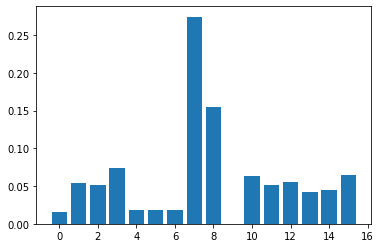

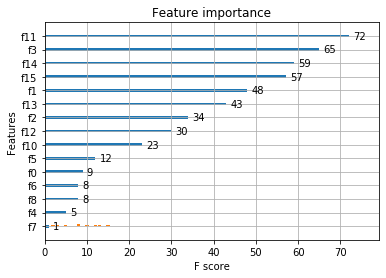

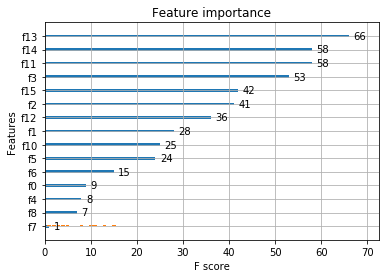

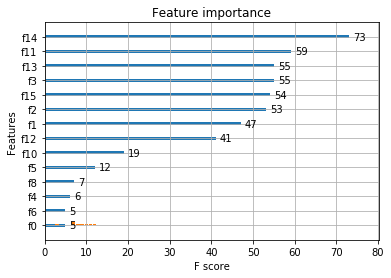

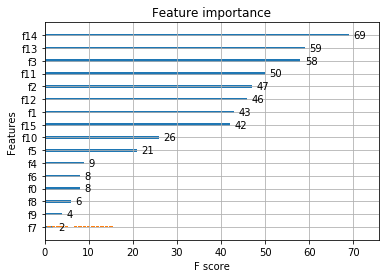

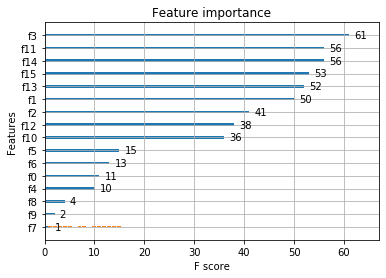

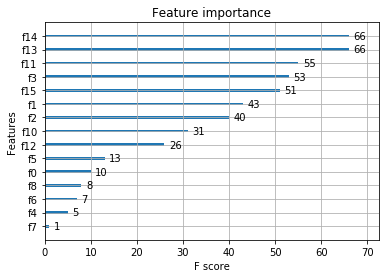

In [415]:
first_time = True
comb = compute_comb(params)
print(comb[0])
idx_aver = []
idx_vot = []
accuracy, specificity, sensitivity, auc = my_cross_val( 10, train_total, test_total, train_total_NoCvd, train_total_Cvd,comb[0])

In [416]:
from statistics import mean
print(mean(accuracy))
print(mean(specificity))
print(mean(sensitivity))
print(mean(auc))

0.6892857142857143
0.6899698340874811
0.69
0.6899849170437405


In [15]:
# https://www.geeksforgeeks.org/python-all-possible-permutations-of-n-lists/

def compute_comb(params):
    
    # initializing lists 
    list1 = params.get("learning_rate")
    list2 = params.get("max_depth")
    list3 = params.get("n_estimators") 
    list4 = params.get("min_child_weight")
    list5 = params.get("gamma")    
    list6 = params.get("colsample_bylevel")
    list7 = params.get("reg_lambda") 
    list8 = params.get("scale_pos_weight")
    list9 = params.get("colsample_bytree")
    list10 = params.get("reg_alpha")
    list11 = params.get("subsample")
    

#     # printing lists  
#     print ("The original lists are : " + str(list1) +
#                                    " " + str(list2) + 
#                                    " " + str(list3) + 
#                                    " " + str(list4) + 
#                                    " " + str(list5) + 
#                                    " " + str(list6) +
#                                    " " + str(list7) +
#                                    " " + str(list8)) 

    # using list comprehension  
    # to compute all possible permutations 
    res = [[i, j, k, l, m, n, o, p,q,r,s] for i in list1  
                                          for j in list2 
                                          for k in list3 
                                          for l in list4 
                                          for m in list5 
                                          for n in list6 
                                          for o in list7
                                          for p in list8
                                          for q in list9
                                          for r in list10
                                          for s in list11] 

    # printing result 
#     print ("All possible permutations are : " +  str(res))
    return res

In [16]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [17]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from statistics import mean

def gridsearch(params):
    max_sens = 0
    max_spes = 0
    max_acc = 0
    best_params = []
    max_params = []
    max_auc = 0
    best_params_total = []
    
    MAX_auc = 0
    MAX_spec = 0
    MAX_sens = 0 
    MAX_acc = 0
    MAX_comd = []
    MAX_feat = []
    INDEXES = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] 
    
    combs = compute_comb(params)
    print(len(combs))
    for j in range(len(combs)):
#         first_time = True
        f_size = 16
    
        print (j, end="\r")
#         print(j)
        accuracy, specificity, sensitivity, auc,idx_aver,idx_vot = my_cross_val(f_size, 10, train_total, test_total,validation_total,train_total_NoCvd, train_total_Cvd,combs[j],[],[],True)
#         print("all features",idx_aver)
#         if mean(sensitivity)> 0.5 and mean(specificity)>0.6 and mean(accuracy)>0.6 and mean(auc)>0.5:
#             print(style.BOLD + "----------------------------------------------------------------"+ style.END)
#             print(combs[j])
#             print (style.BOLD + 'accuracy    ' + style.END, mean(accuracy))
#             print (style.BOLD + 'specificity ' + style.END, mean(specificity))
#             print (style.BOLD + 'sensitivity ' + style.END, mean(sensitivity))
#             print (style.BOLD + 'auc         ' + style.END, mean(auc))
#             print(style.BOLD + "----------------------------------------------------------------"+ style.END)
#         else:
#             print(combs[j])
#             print("accuracy    ",mean(accuracy))
#             print("specificity ",mean(specificity))
#             print("sensitivity ",mean(sensitivity))
#             print("auc         ",mean(auc))
            
        best_params.append([combs[j],mean(accuracy),mean(specificity),mean(sensitivity),mean(auc)])
        if mean(auc)> max_auc:
            max_sens = mean(sensitivity)
            max_spes = mean(specificity)
            max_acc = mean(accuracy)
            max_auc = mean(auc)
            max_params = combs[j]
         
        for k in range(len(idx_aver)-1):
            INDEXES[idx_aver[k]] += len(idx_aver)-k-1
        MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comd,MAX_feat,best_params_total = features_combinations(combs[j],idx_aver,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comd,MAX_feat,best_params_total)
    return max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comd,MAX_feat,INDEXES,best_params_total

In [18]:
a = [[1,2,3,4,5,6],[1,2,3,4,5,6]]
a1=np.delete(a, [0,3], axis=1)
print(a1)

[[2 3 5 6]
 [2 3 5 6]]


In [19]:
import matplotlib.pyplot as plt
# plt.plot([1, 2, 3, 4])
# plt.ylabel('some numbers')
# plt.show()
# print(data)
def features_combinations(comb,idx_aver,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comd,MAX_feat,best_params_total):
    first_time = False
    total_auc = []
    max_auc_local = 0
    max_acc_local = 0
    max_sens_local = 0
    max_spec_local = 0
    max_feat_local = []
    for i in range(16):
        included_feat = idx_aver.copy()

        f_size = i+1
        del included_feat[-1]
        del included_feat[0:f_size]

        dataNoCvd1 = data[~(data[:,16] > 0.0)]
        dataCvd1 = data[~(data[:,16] < 1.0)]
        dataNoCvd2=np.delete(dataNoCvd1, included_feat, axis=1)
        dataCvd2=np.delete(dataCvd1, included_feat, axis=1)

        train_total1, test_total1, validation_total1, train_total_NoCvd1, train_total_Cvd1 = create_train_test_sets(f_size,10,dataNoCvd2,dataCvd2,0.1)

        acc, spec, sens, Auc,id_a,id_v = my_cross_val(f_size, 10, train_total1, test_total1,validation_total1,train_total_NoCvd1, train_total_Cvd1,comb,[],[],first_time)

        if max_auc_local<mean(Auc):
            max_auc_local = mean(Auc)
            max_acc_local = mean(acc)
            max_sens_local = mean(sens)
            max_spec_local = mean(spec)
#             print(idx_aver)
#             print(included_feat)
            max_feat_local = idx_aver.copy()
            for k in range(len(included_feat)):
                max_feat_local.remove(included_feat[k])
            max_feat_local.remove(16)
                
        total_auc.append(mean(Auc))
    if(max_auc_local> 0.68):   
        print (style.BOLD + 'new features' + style.END, max_feat_local)    
        print(comb)
        print (style.BOLD + 'accuracy    ' + style.END, max_acc_local)
        print (style.BOLD + 'specificity ' + style.END, max_spec_local)
        print (style.BOLD + 'sensitivity ' + style.END, max_sens_local)
        print (style.BOLD + 'auc         ' + style.END, max_auc_local)
        
        plt.figure(figsize=(10,4))
        names = []
        for j in range(len(total_auc)):
            names.append(str(idx_aver[j]))
        plt.plot(names,total_auc)
        # plt.ylabel(idx_aver)
        plt.show()
        
    best_params_total.append([comb,max_acc_local,max_spec_local,max_sens_local,max_auc_local,max_feat_local,idx_aver])
   
    

    if max_auc_local>MAX_auc:
        MAX_auc = max_auc_local
        MAX_comd = comb
        MAX_feat = max_feat_local
        MAX_sens = max_sens_local
        MAX_spec = max_spec_local
        MAX_acc = max_acc_local
        
    

# plt.plot(names, values)
# plt.suptitle('Categorical Plotting')
# plt.show()
    return MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comd,MAX_feat,best_params_total

In [301]:
a=[3, 13, 14, 11, 15, 2, 1, 12, 10, 5, 0, 4, 6, 8, 7, 9, 16]
b = [6, 8, 7, 9]


kk = a.remove(b)
print(kk)

ValueError: list.remove(x): x not in list

In [21]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.4],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2,3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1,2,3,4],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0,0.5,1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5,0.75,1], #0.5-1
                     "reg_lambda"      :[1, 1.5, 2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3,4,5],
                    "colsample_bytree" :[0.5,0.75,1.0],
                    "reg_alpha"        :[0],
                    "subsample"        :[0.8,1.0]
    
        }

3888
new features [10, 8, 15, 3, 7, 1, 13, 14, 5, 11, 9, 2, 12, 6]
[0.4, 2, 1000, 1, 0, 0.5, 1.5, 5, 0.75, 0, 0.8]
accuracy     0.6053571428571428
specificity  0.5918929110105581
sensitivity  0.785
auc          0.688446455505279


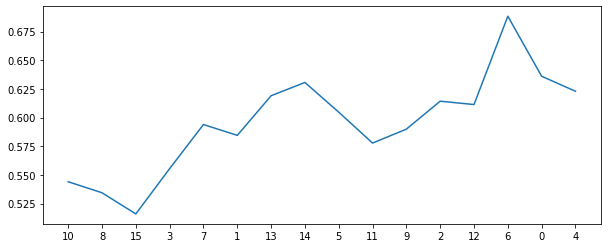

new features [7, 2, 15, 8, 3]
[0.4, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0, 0.8]
accuracy     0.6571428571428571
specificity  0.6494720965309201
sensitivity  0.765
auc          0.70723604826546


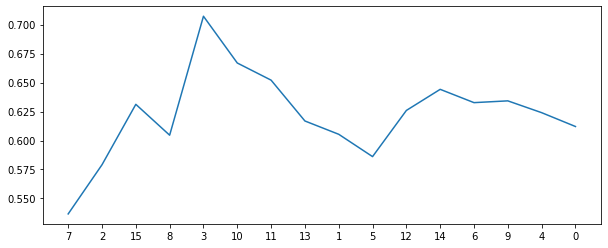

new features [9, 8, 15, 7, 3, 10, 2]
[0.4, 2, 1000, 1, 0, 1, 1, 3, 0.5, 0, 0.8]
accuracy     0.6482142857142857
specificity  0.6437028657616893
sensitivity  0.72
auc          0.6818514328808446


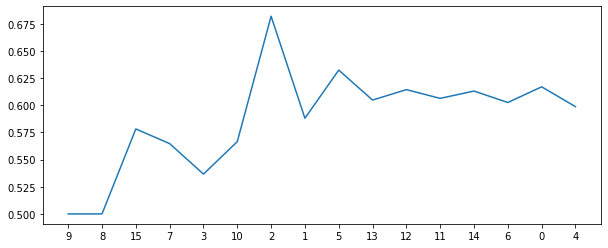

new features [15, 3, 7, 13, 6, 10, 8, 5, 1, 14, 12, 2, 11]
[0.4, 2, 1000, 1, 0.5, 0.5, 1, 4, 1.0, 0, 1.0]
accuracy     0.575
specificity  0.5570135746606335
sensitivity  0.81
auc          0.6835067873303168


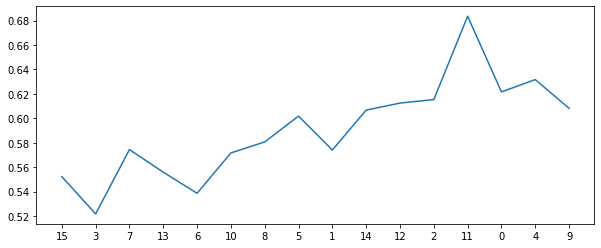

new features [8, 15, 10, 9, 3, 11, 1, 2, 13, 14]
[0.4, 2, 1000, 2, 0, 0.5, 2, 5, 1.0, 0, 0.8]
accuracy     0.6017857142857143
specificity  0.5878205128205128
sensitivity  0.785
auc          0.6864102564102564


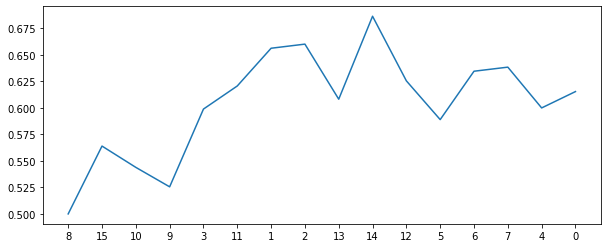

new features [15, 10, 13, 3, 11, 1, 14, 2, 12, 5, 8, 4, 0, 9]
[0.4, 2, 1000, 2, 1, 0.5, 2, 3, 0.5, 0, 1.0]
accuracy     0.6303571428571428
specificity  0.6207013574660634
sensitivity  0.76
auc          0.6903506787330317


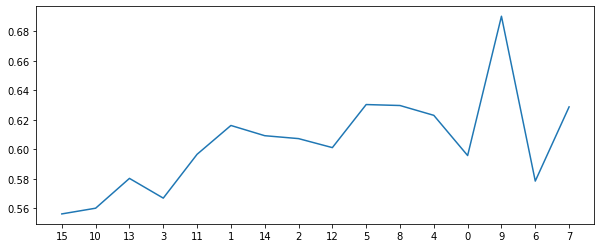

new features [10, 8, 15, 13, 1, 3, 14, 5, 11, 2, 12, 0, 7, 6, 4, 9]
[0.4, 2, 1000, 3, 0, 0.5, 1.5, 4, 0.75, 0, 1.0]
accuracy     0.5875
specificity  0.5706259426847662
sensitivity  0.81
auc          0.6903129713423831


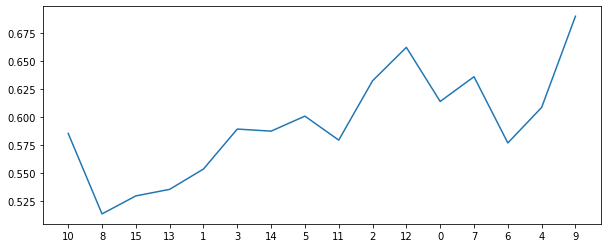

new features [8, 15, 10, 3, 2, 11]
[0.4, 2, 1000, 3, 0, 0.75, 1, 4, 0.5, 0, 1.0]
accuracy     0.6035714285714285
specificity  0.5917420814479638
sensitivity  0.77
auc          0.6808710407239819


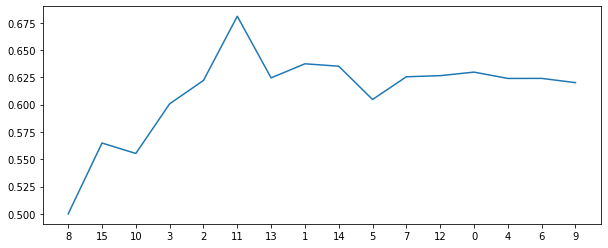

new features [15, 12, 13, 3, 10, 11, 8, 2, 14]
[0.4, 2, 1000, 3, 1, 0.5, 1.5, 3, 0.5, 0, 1.0]
accuracy     0.6142857142857143
specificity  0.6033559577677224
sensitivity  0.765
auc          0.6841779788838612


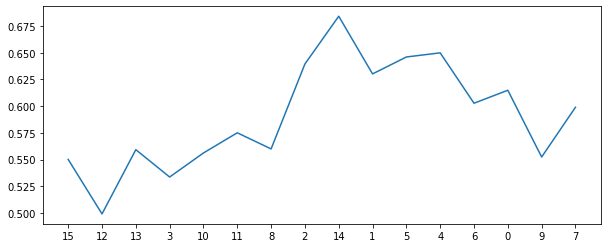

new features [15, 8, 10, 3, 2, 1, 13, 12, 11, 14]
[0.4, 2, 1000, 3, 1, 0.75, 1, 4, 1.0, 0, 0.8]
accuracy     0.6125
specificity  0.6013197586726998
sensitivity  0.76
auc          0.68065987933635


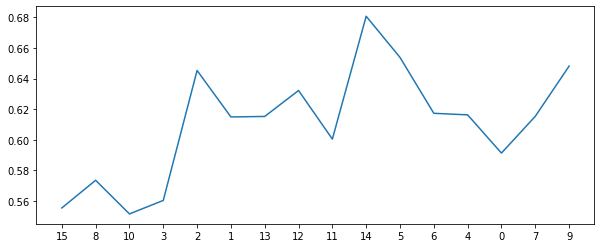

new features [15, 10, 8, 13, 3, 11, 1, 12, 5, 4, 14, 2, 0]
[0.4, 2, 1000, 4, 0, 0.75, 2, 3, 1.0, 0, 1.0]
accuracy     0.6392857142857143
specificity  0.6321644042232277
sensitivity  0.735
auc          0.6835822021116139


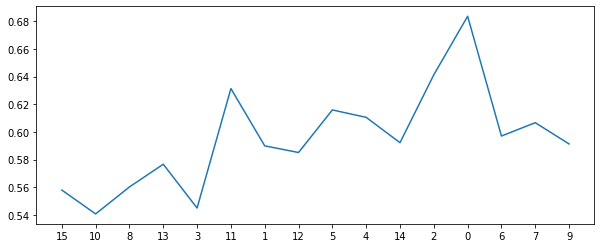

new features [8, 15, 10, 3, 11, 2]
[0.4, 2, 1000, 4, 0.5, 1, 1.5, 5, 1.0, 0, 0.8]
accuracy     0.5875
specificity  0.5705128205128205
sensitivity  0.815
auc          0.6927564102564102


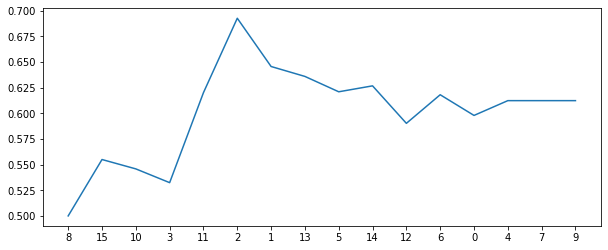

new features [15, 10, 3, 13, 11, 14, 1, 8, 12, 2]
[0.4, 2, 1000, 4, 1, 0.5, 1, 3, 0.5, 0, 1.0]
accuracy     0.5946428571428571
specificity  0.5801282051282051
sensitivity  0.785
auc          0.6825641025641026


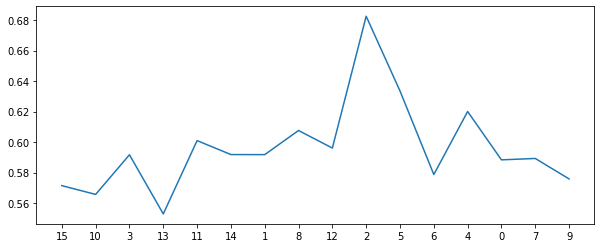

new features [9, 13, 8, 15, 3, 11, 10, 7, 2, 1, 14, 4, 6, 12]
[0.4, 3, 1000, 1, 0, 0.75, 1, 4, 0.5, 0, 1.0]
accuracy     0.6267857142857143
specificity  0.616817496229261
sensitivity  0.765
auc          0.6909087481146304


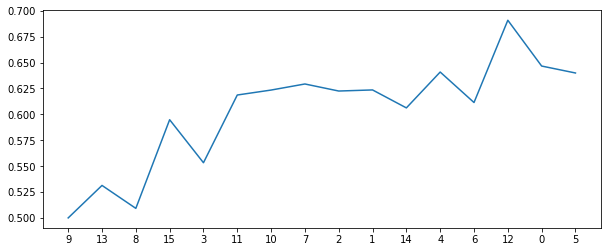

new features [15, 7, 3, 8, 1, 13, 6, 11, 14]
[0.4, 3, 1000, 1, 0.5, 1, 2, 4, 0.75, 0, 1.0]
accuracy     0.5964285714285714
specificity  0.5820889894419307
sensitivity  0.785
auc          0.6835444947209653


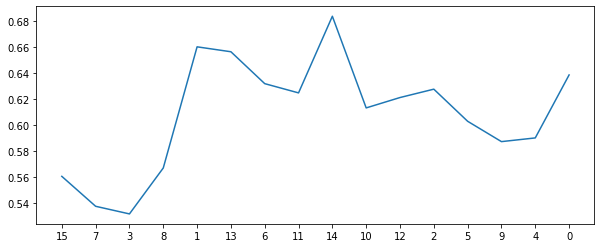

new features [15, 3, 13, 1, 5, 8, 14, 7, 12, 11, 10, 6, 2, 9]
[0.4, 3, 1000, 1, 1, 0.5, 1.5, 5, 1.0, 0, 0.8]
accuracy     0.5714285714285714
specificity  0.5533936651583711
sensitivity  0.81
auc          0.6816968325791856


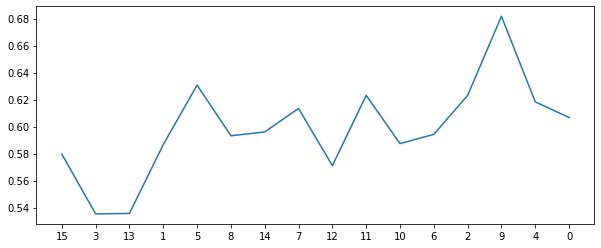

new features [8, 7, 15, 3, 14, 1, 2, 5, 13, 10, 11]
[0.4, 3, 1000, 1, 1, 0.75, 1, 5, 0.5, 0, 0.8]
accuracy     0.6
specificity  0.5860105580693816
sensitivity  0.79
auc          0.6880052790346908


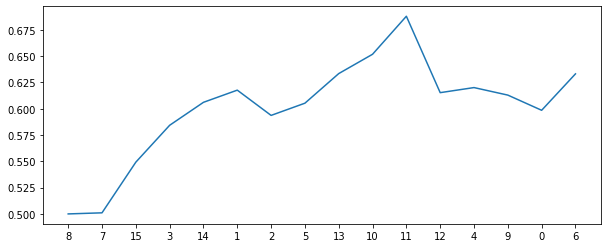

new features [15, 8, 3, 7, 14, 10, 1, 11, 5, 2, 13]
[0.4, 3, 1000, 1, 1, 0.75, 2, 5, 0.5, 0, 0.8]
accuracy     0.5696428571428571
specificity  0.5512820512820513
sensitivity  0.81
auc          0.6806410256410257


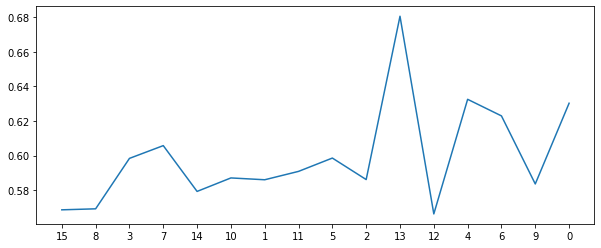

new features [8, 15, 13, 10, 1, 3, 11, 12, 2, 14, 6, 4, 5, 7]
[0.4, 3, 1000, 3, 0, 0.5, 1, 4, 0.5, 0, 1.0]
accuracy     0.625
specificity  0.6148190045248869
sensitivity  0.76
auc          0.6874095022624435


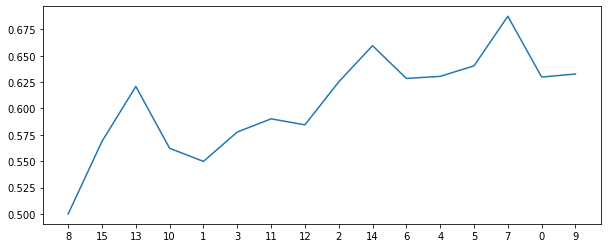

new features [10, 15, 3, 8, 2, 6, 1, 13]
[0.4, 3, 1000, 3, 0.5, 0.5, 1.5, 3, 1.0, 0, 0.8]
accuracy     0.6607142857142857
specificity  0.6572021116138763
sensitivity  0.71
auc          0.6836010558069381


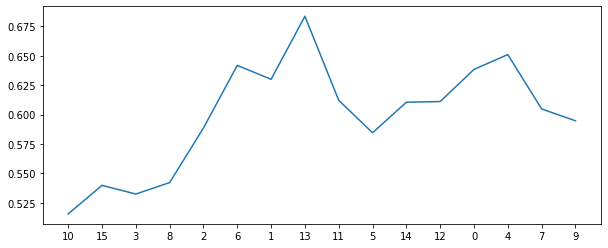

new features [8, 15, 13, 3, 10, 1, 11, 2]
[0.4, 3, 1000, 3, 0.5, 0.5, 2, 5, 0.5, 0, 1.0]
accuracy     0.5607142857142857
specificity  0.5397435897435897
sensitivity  0.835
auc          0.6873717948717949


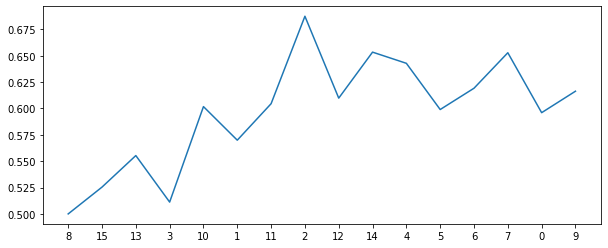

new features [8, 15, 10, 3, 14, 5, 2, 13, 11, 1, 12]
[0.4, 3, 1000, 3, 0.5, 0.75, 2, 4, 0.5, 0, 0.8]
accuracy     0.5964285714285714
specificity  0.5822398190045249
sensitivity  0.785
auc          0.6836199095022625


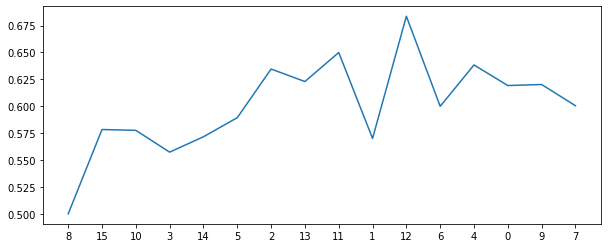

new features [15, 8, 1, 2, 3, 12]
[0.4, 3, 1000, 3, 1, 1, 2, 4, 1.0, 0, 1.0]
accuracy     0.5446428571428571
specificity  0.5223981900452489
sensitivity  0.84
auc          0.6811990950226244


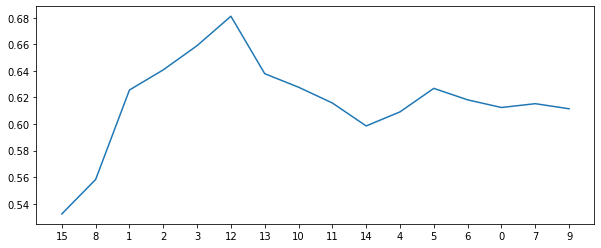

new features [10, 15, 3, 1, 8, 13, 4, 14, 2, 11, 0, 5, 12]
[0.4, 3, 1000, 4, 0, 0.5, 2, 4, 0.75, 0, 1.0]
accuracy     0.5928571428571429
specificity  0.5764328808446455
sensitivity  0.81
auc          0.6932164404223228


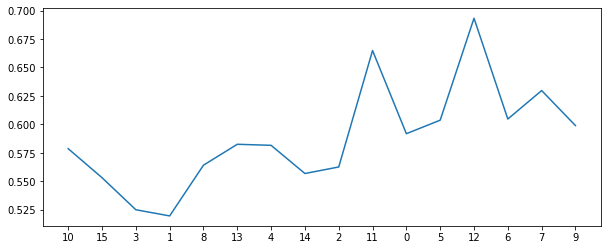

new features [8, 15, 11, 10, 13, 2, 14, 3, 5, 1, 12]
[0.4, 3, 1000, 4, 0, 0.75, 1, 5, 0.5, 0, 0.8]
accuracy     0.5607142857142857
specificity  0.5398190045248868
sensitivity  0.835
auc          0.6874095022624434


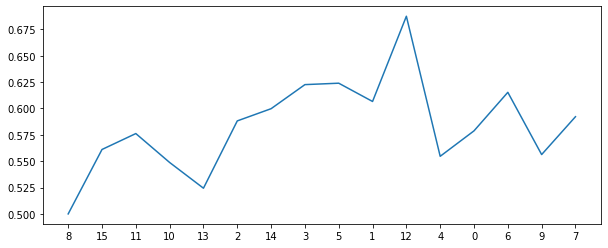

new features [10, 15, 13, 3, 8, 11, 1, 0, 2, 14, 12, 6]
[0.4, 3, 1000, 4, 0.5, 1, 1, 5, 0.75, 0, 1.0]
accuracy     0.5553571428571429
specificity  0.5340874811463047
sensitivity  0.835
auc          0.6845437405731524


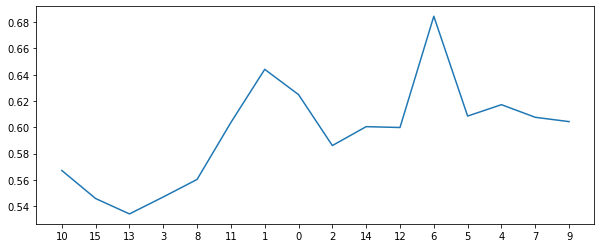

In [22]:
### MAX_auc = 0
max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comb,MAX_feat,INDEXES,best_params_total= gridsearch(params)

In [23]:
print(MAX_feat)
print(MAX_comb)
print(MAX_acc)
print(MAX_spec)
print(MAX_sens)
print(MAX_auc)

[7, 2, 15, 8, 3]
[0.4, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0, 0.8]
0.6571428571428571
0.6494720965309201
0.765
0.70723604826546


In [24]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params_total)):
    if best_params_total[i][4] > 0.69:
        print("parameters :",best_params_total[i][0])
        print("accuracy :",best_params_total[i][1])
        print("spes     :",best_params_total[i][2])
        print("sens     :",best_params_total[i][3])
        print("auc      :",best_params_total[i][4])
        print(best_params_total[i][5])
        print(best_params_total[i][6])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.4, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0, 0.8]
accuracy : 0.6571428571428571
spes     : 0.6494720965309201
sens     : 0.765
auc      : 0.70723604826546
[7, 2, 15, 8, 3]
[7, 2, 15, 8, 3, 10, 11, 13, 1, 5, 12, 14, 6, 9, 4, 0, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 2, 1, 0.5, 2, 3, 0.5, 0, 1.0]
accuracy : 0.6303571428571428
spes     : 0.6207013574660634
sens     : 0.76
auc      : 0.6903506787330317
[15, 10, 13, 3, 11, 1, 14, 2, 12, 5, 8, 4, 0, 9]
[15, 10, 13, 3, 11, 1, 14, 2, 12, 5, 8, 4, 0, 9, 6, 7, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 3, 0, 0.5, 1.5, 4, 0.75, 0, 1.0]
accuracy : 0.5875
spes     : 0.5706259426847662
sens     : 0.81
auc      : 0.6903129713423831
[10, 8, 15, 13, 1, 3, 14, 5, 11, 2, 12, 0, 7, 6, 4, 9]
[10, 8, 15, 13, 1, 3, 14, 5, 11, 2, 12, 0, 7, 6, 4, 9, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 4, 0.5, 1, 1.5, 5, 1.0, 0, 0.8]
accuracy : 0.

In [25]:
IND = []
for i in range(len(INDEXES)):
    IND.append(INDEXES[i]//min(INDEXES))
print(IND)

[1, 2, 2, 3, 1, 1, 1, 1, 3, 1, 3, 2, 1, 3, 2, 3]


In [26]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.4],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2,3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1,2,3,4],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0,0.5,1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5,0.75,1], #0.5-1
                     "reg_lambda"      :[1, 1.5, 2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3,4,5],
                    "colsample_bytree" :[0.5,0.75,1.0],
                    "reg_alpha"        :[0.1],
                    "subsample"        :[0.8,1.0]
    
        }

3888
new features [8, 10, 15, 7, 3, 2, 13, 1, 14, 11, 5, 9, 12, 6]
[0.4, 2, 1000, 1, 0, 0.5, 2, 4, 0.75, 0.1, 0.8]
accuracy     0.6357142857142857
specificity  0.628393665158371
sensitivity  0.735
auc          0.6816968325791856


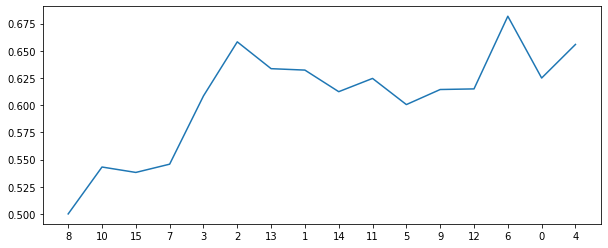

new features [9, 15, 3, 2, 13, 10, 14, 11, 4, 5, 6, 12, 1, 8, 7]
[0.4, 2, 1000, 1, 0.5, 0.5, 1, 5, 0.5, 0.1, 0.8]
accuracy     0.6160714285714286
specificity  0.6053167420814479
sensitivity  0.76
auc          0.6826583710407239


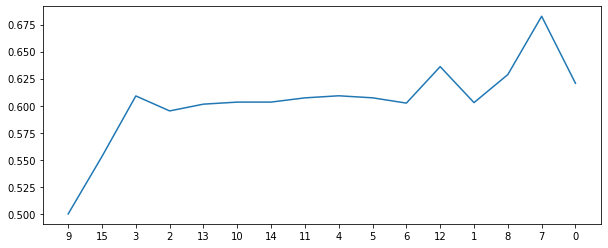

new features [5, 15, 13, 10, 3, 1, 14, 8, 11, 2, 4, 6, 12, 0]
[0.4, 2, 1000, 2, 0.5, 0.5, 2, 5, 0.75, 0.1, 1.0]
accuracy     0.5482142857142858
specificity  0.5264705882352941
sensitivity  0.835
auc          0.6807352941176471


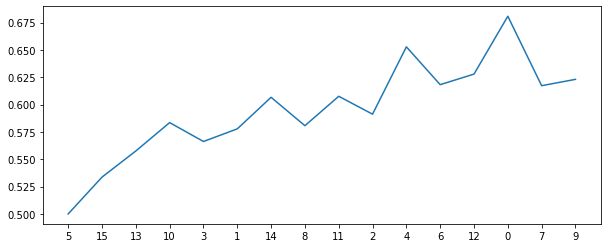

new features [8, 15, 10, 3, 9, 2, 11]
[0.4, 2, 1000, 2, 0.5, 0.75, 2, 4, 0.5, 0.1, 0.8]
accuracy     0.5982142857142857
specificity  0.5840497737556561
sensitivity  0.79
auc          0.687024886877828


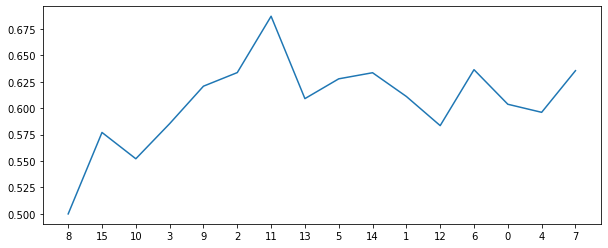

new features [8, 15, 3, 10, 2, 13, 14, 11, 12]
[0.4, 2, 1000, 2, 1, 0.75, 1.5, 3, 0.5, 0.1, 0.8]
accuracy     0.6285714285714286
specificity  0.6207013574660634
sensitivity  0.74
auc          0.6803506787330317


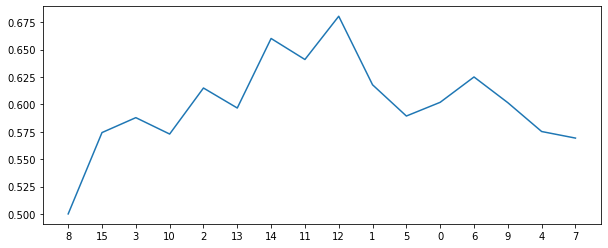

new features [10, 8, 15, 13, 1, 3, 11, 14, 5, 2, 6, 12, 4, 7, 0, 9]
[0.4, 2, 1000, 3, 0, 0.5, 1, 5, 0.75, 0.1, 1.0]
accuracy     0.5446428571428571
specificity  0.5205882352941177
sensitivity  0.86
auc          0.6902941176470588


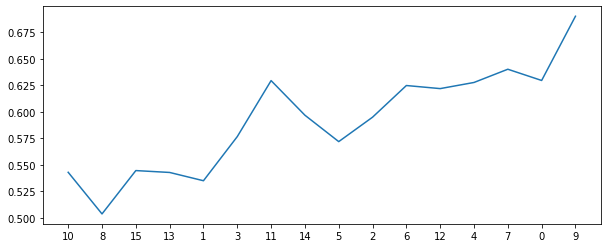

new features [15, 10, 3, 13, 8, 2, 11]
[0.4, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.5, 0.1, 0.8]
accuracy     0.6285714285714286
specificity  0.6206636500754148
sensitivity  0.74
auc          0.6803318250377074


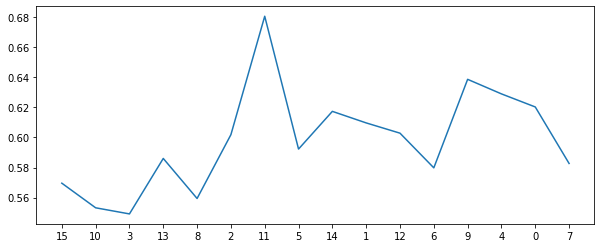

new features [15, 8, 13, 10, 3, 14, 11, 1, 12, 5, 2]
[0.4, 2, 1000, 4, 0, 0.5, 1.5, 3, 0.5, 0.1, 1.0]
accuracy     0.6142857142857143
specificity  0.603393665158371
sensitivity  0.76
auc          0.6816968325791856


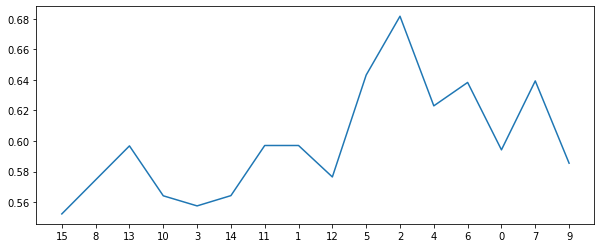

new features [15, 8, 13, 10, 3, 14, 11, 1, 2, 12, 6]
[0.4, 2, 1000, 4, 0, 0.5, 2, 3, 0.5, 0.1, 1.0]
accuracy     0.6232142857142857
specificity  0.6111236802413273
sensitivity  0.785
auc          0.6980618401206636


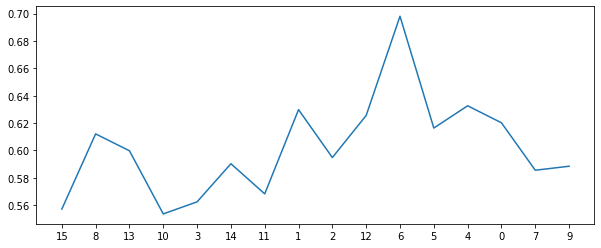

new features [15, 8, 13, 3, 11, 10, 2]
[0.4, 2, 1000, 4, 0.5, 1, 1.5, 3, 0.5, 0.1, 0.8]
accuracy     0.6214285714285714
specificity  0.6108220211161388
sensitivity  0.765
auc          0.6879110105580694


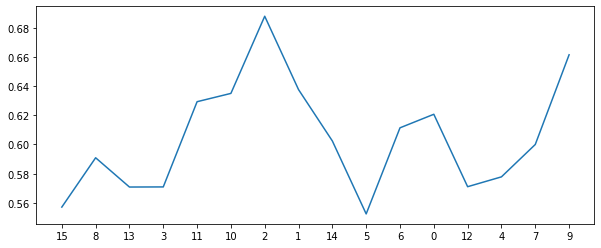

new features [7, 8, 9, 15, 3, 13, 1, 11, 10]
[0.4, 3, 1000, 1, 0, 1, 1.5, 3, 0.75, 0.1, 1.0]
accuracy     0.6553571428571429
specificity  0.6513574660633484
sensitivity  0.715
auc          0.6831787330316742


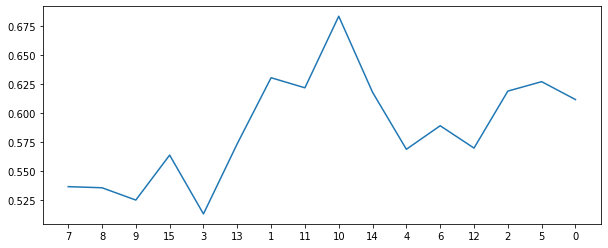

new features [15, 3, 14, 9, 8, 2, 10, 7, 5]
[0.4, 3, 1000, 1, 1, 0.75, 1, 5, 0.5, 0.1, 0.8]
accuracy     0.5946428571428571
specificity  0.5804675716440422
sensitivity  0.785
auc          0.6827337858220212


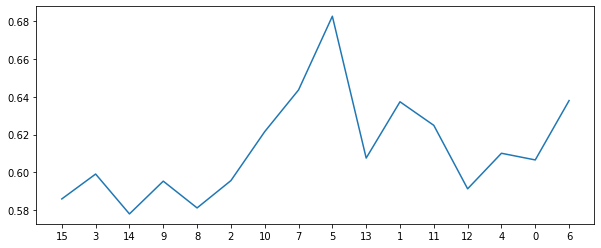

new features [8, 10, 15, 1, 11, 3]
[0.4, 3, 1000, 2, 0, 0.5, 2, 3, 0.75, 0.1, 0.8]
accuracy     0.6625
specificity  0.6591251885369532
sensitivity  0.715
auc          0.6870625942684766


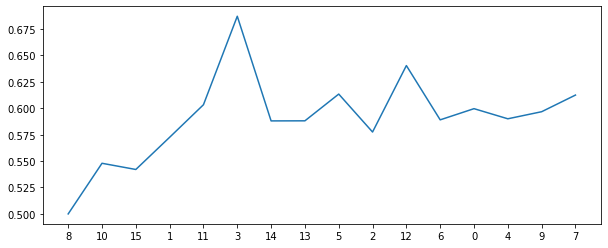

new features [8, 9, 13, 10, 3, 15, 11, 4, 2, 1]
[0.4, 3, 1000, 2, 0, 0.75, 1, 5, 0.5, 0.1, 1.0]
accuracy     0.5732142857142857
specificity  0.5532805429864254
sensitivity  0.835
auc          0.6941402714932127


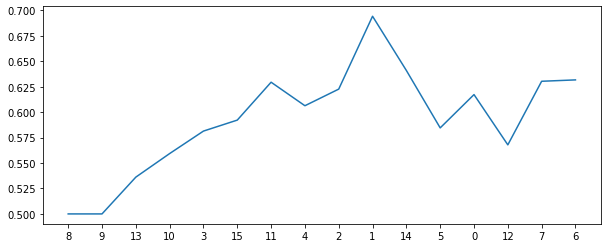

new features [13, 3, 12, 4, 10, 8, 9, 15, 1, 11, 2, 14, 0]
[0.4, 3, 1000, 2, 0.5, 0.5, 1, 5, 0.5, 0.1, 1.0]
accuracy     0.5732142857142857
specificity  0.5551282051282052
sensitivity  0.81
auc          0.6825641025641026


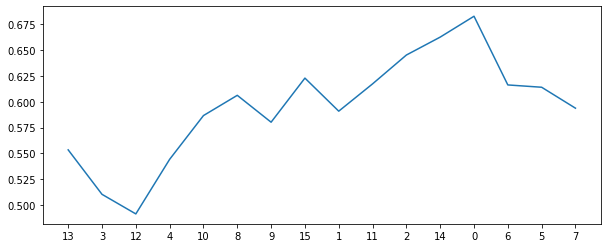

new features [8, 10, 15, 1, 3, 11, 14, 13, 5, 2, 12, 0, 6, 4]
[0.4, 3, 1000, 3, 0, 0.5, 1.5, 4, 0.75, 0.1, 0.8]
accuracy     0.65
specificity  0.6418929110105581
sensitivity  0.76
auc          0.700946455505279


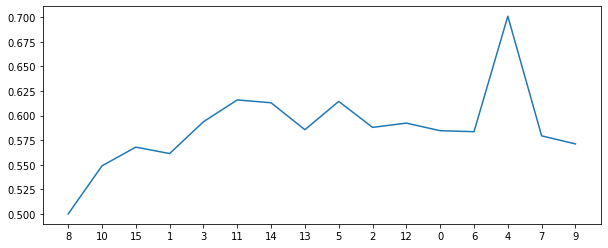

new features [8, 15, 10, 1, 3, 5, 2, 11]
[0.4, 3, 1000, 3, 0, 1, 1.5, 5, 0.75, 0.1, 0.8]
accuracy     0.6125
specificity  0.601395173453997
sensitivity  0.765
auc          0.6831975867269985


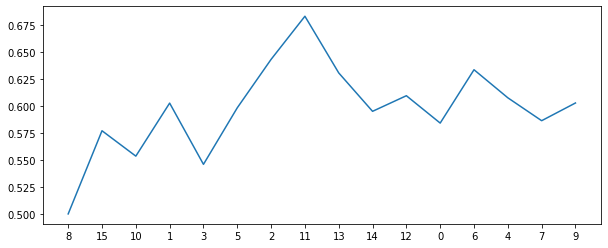

new features [8, 10, 15, 2, 1, 3]
[0.4, 3, 1000, 3, 0.5, 1, 1.5, 4, 0.75, 0.1, 0.8]
accuracy     0.6285714285714286
specificity  0.6206259426847662
sensitivity  0.74
auc          0.6803129713423831


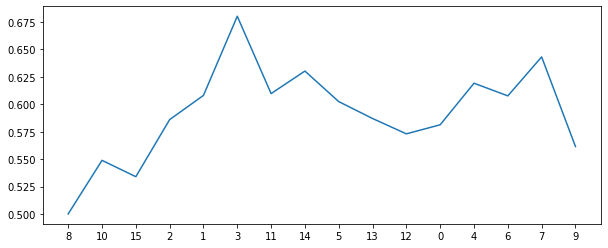

new features [15, 8, 13, 3, 10, 1, 11, 12, 2, 14, 4]
[0.4, 3, 1000, 4, 0, 0.5, 1.5, 3, 0.5, 0.1, 1.0]
accuracy     0.6410714285714285
specificity  0.6341251885369532
sensitivity  0.735
auc          0.6845625942684767


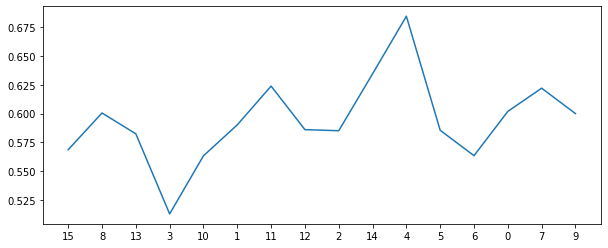

new features [10, 15, 8, 13, 3, 11, 2, 1, 14, 12, 6]
[0.4, 3, 1000, 4, 0, 0.5, 2, 4, 0.5, 0.1, 1.0]
accuracy     0.5821428571428572
specificity  0.564894419306184
sensitivity  0.81
auc          0.687447209653092


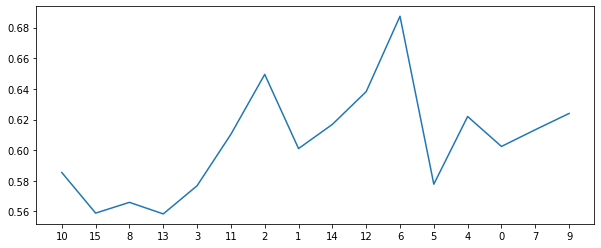

new features [15, 10, 8, 3, 11, 13, 14, 4, 1, 2, 5]
[0.4, 3, 1000, 4, 0.5, 0.75, 2, 3, 0.5, 0.1, 1.0]
accuracy     0.6464285714285715
specificity  0.639894419306184
sensitivity  0.735
auc          0.6874472096530919


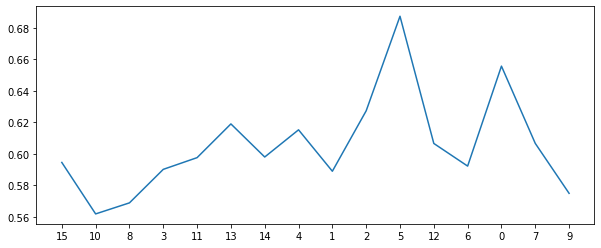

new features [15, 3, 10, 8, 11, 13, 4, 1, 2]
[0.4, 3, 1000, 4, 0.5, 1, 1, 3, 0.5, 0.1, 1.0]
accuracy     0.6375
specificity  0.6303544494720965
sensitivity  0.74
auc          0.6851772247360483


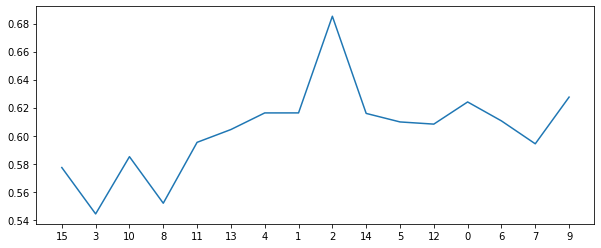

new features [8, 15, 3, 10, 11, 13, 14, 2]
[0.4, 3, 1000, 4, 0.5, 1, 1, 4, 0.75, 0.1, 1.0]
accuracy     0.6071428571428571
specificity  0.5955882352941176
sensitivity  0.765
auc          0.6802941176470588


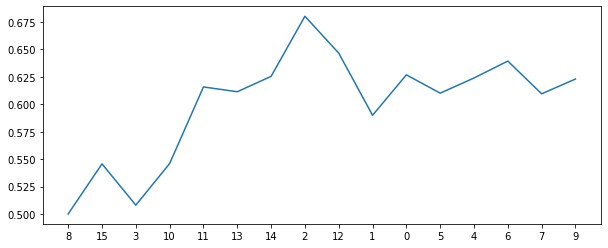

new features [10, 13, 15, 3, 8, 14, 1, 11, 2, 12, 5, 4, 0]
[0.4, 3, 1000, 4, 1, 0.5, 1.5, 3, 0.75, 0.1, 1.0]
accuracy     0.6303571428571428
specificity  0.6207013574660634
sensitivity  0.76
auc          0.6903506787330317


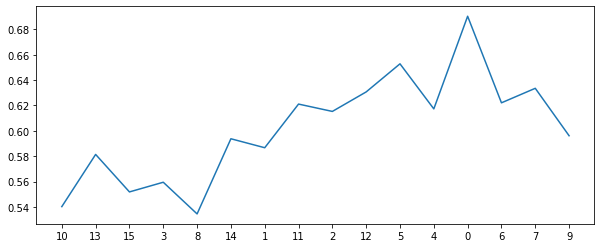

new features [15, 8, 3, 11, 13, 10, 14, 1, 2, 12]
[0.4, 3, 1000, 4, 1, 1, 1, 3, 0.5, 0.1, 1.0]
accuracy     0.6357142857142857
specificity  0.6282805429864253
sensitivity  0.735
auc          0.6816402714932127


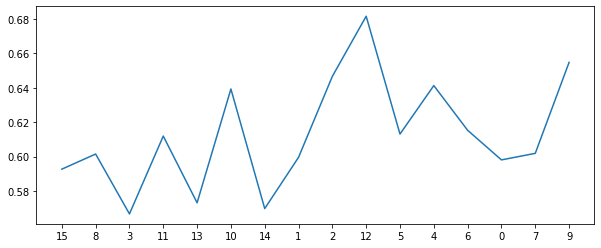

In [27]:
max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comb,MAX_feat,INDEXES,best_params_total= gridsearch(params)

In [28]:
print(MAX_feat)
print(MAX_comb)
print(MAX_acc)
print(MAX_spec)
print(MAX_sens)
print(MAX_auc)

[8, 10, 15, 1, 3, 11, 14, 13, 5, 2, 12, 0, 6, 4]
[0.4, 3, 1000, 3, 0, 0.5, 1.5, 4, 0.75, 0.1, 0.8]
0.65
0.6418929110105581
0.76
0.700946455505279


In [29]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params_total)):
    if best_params_total[i][4] > 0.69:
        print("parameters :",best_params_total[i][0])
        print("accuracy :",best_params_total[i][1])
        print("spes     :",best_params_total[i][2])
        print("sens     :",best_params_total[i][3])
        print("auc      :",best_params_total[i][4])
        print(best_params_total[i][5])
        print(best_params_total[i][6])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.4, 2, 1000, 3, 0, 0.5, 1, 5, 0.75, 0.1, 1.0]
accuracy : 0.5446428571428571
spes     : 0.5205882352941177
sens     : 0.86
auc      : 0.6902941176470588
[10, 8, 15, 13, 1, 3, 11, 14, 5, 2, 6, 12, 4, 7, 0, 9]
[10, 8, 15, 13, 1, 3, 11, 14, 5, 2, 6, 12, 4, 7, 0, 9, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 4, 0, 0.5, 2, 3, 0.5, 0.1, 1.0]
accuracy : 0.6232142857142857
spes     : 0.6111236802413273
sens     : 0.785
auc      : 0.6980618401206636
[15, 8, 13, 10, 3, 14, 11, 1, 2, 12, 6]
[15, 8, 13, 10, 3, 14, 11, 1, 2, 12, 6, 5, 4, 0, 7, 9, 16]
------------------------------------------------
parameters : [0.4, 3, 1000, 2, 0, 0.75, 1, 5, 0.5, 0.1, 1.0]
accuracy : 0.5732142857142857
spes     : 0.5532805429864254
sens     : 0.835
auc      : 0.6941402714932127
[8, 9, 13, 10, 3, 15, 11, 4, 2, 1]
[8, 9, 13, 10, 3, 15, 11, 4, 2, 1, 14, 5, 0, 12, 7, 6, 16]
------------------------------------------------
parameters : [0.4, 3, 1000, 3, 0, 0.5, 1.5, 

In [30]:
IND = []
for i in range(len(INDEXES)):
    IND.append(INDEXES[i]//min(INDEXES))
print(IND)

[1, 2, 2, 3, 1, 1, 1, 1, 3, 1, 3, 2, 1, 3, 2, 4]


In [31]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.4],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2,3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1,2,3,4],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0,0.5,1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5,0.75,1], #0.5-1
                     "reg_lambda"      :[1, 1.5, 2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3,4,5],
                    "colsample_bytree" :[0.5,0.75,1.0],
                    "reg_alpha"        :[0.2],
                    "subsample"        :[0.8,1.0]
    
        }

3888
new features [7, 3, 15, 13, 8, 10, 5, 11, 1, 2, 14, 12, 6, 9]
[0.4, 2, 1000, 1, 0, 0.5, 1.5, 5, 1.0, 0.2, 0.8]
accuracy     0.6017857142857143
specificity  0.5861236802413273
sensitivity  0.81
auc          0.6980618401206636


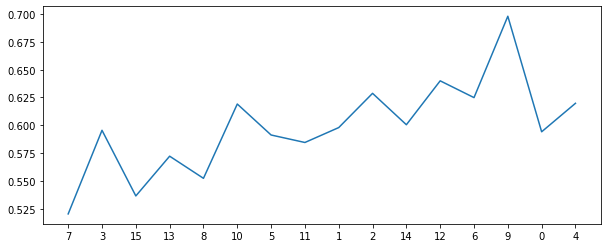

new features [15, 7, 3, 2, 8]
[0.4, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0.2, 0.8]
accuracy     0.6553571428571429
specificity  0.6475490196078432
sensitivity  0.77
auc          0.7087745098039215


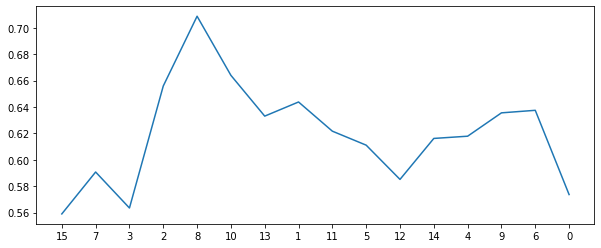

new features [8, 10, 3, 15, 13, 9, 11, 1, 2, 14, 5, 6, 12, 0, 4, 7]
[0.4, 2, 1000, 2, 0, 0.5, 1, 4, 0.75, 0.2, 0.8]
accuracy     0.6178571428571429
specificity  0.6072398190045248
sensitivity  0.76
auc          0.6836199095022625


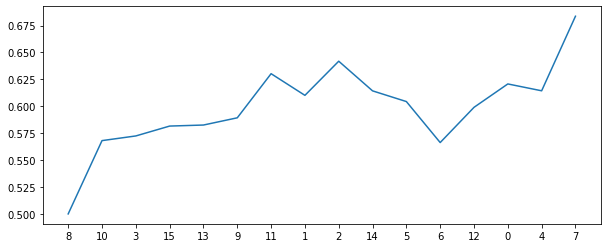

new features [8, 15, 13, 10, 3, 11, 14, 12, 2]
[0.4, 2, 1000, 2, 0, 0.75, 1, 3, 0.5, 0.2, 1.0]
accuracy     0.6589285714285714
specificity  0.655316742081448
sensitivity  0.715
auc          0.685158371040724


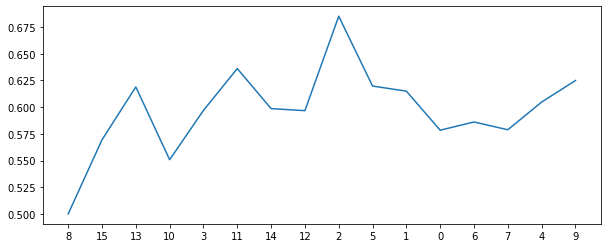

new features [13, 15, 3, 10, 11, 1, 8, 2, 14, 12, 5, 0]
[0.4, 2, 1000, 2, 0.5, 0.5, 1, 3, 0.5, 0.2, 1.0]
accuracy     0.6410714285714285
specificity  0.6342006033182503
sensitivity  0.735
auc          0.6846003016591252


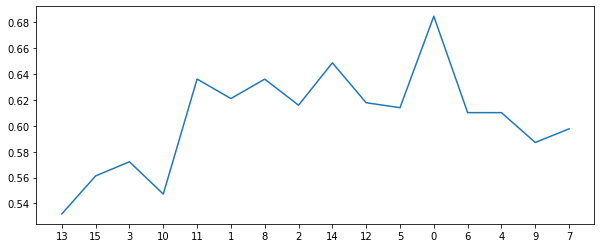

new features [8, 15, 10, 3, 9, 2, 13, 14, 12, 11]
[0.4, 2, 1000, 2, 0.5, 0.75, 1.5, 4, 0.5, 0.2, 0.8]
accuracy     0.5875
specificity  0.5724358974358974
sensitivity  0.79
auc          0.6812179487179487


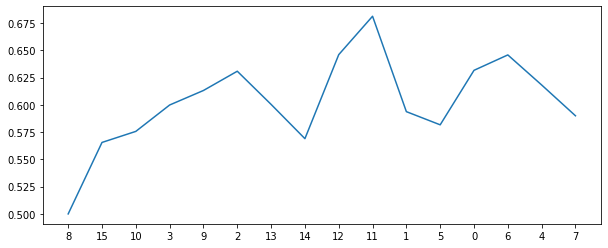

new features [15, 3, 10, 13, 5, 2, 14, 11, 1]
[0.4, 2, 1000, 2, 1, 0.5, 1.5, 3, 0.5, 0.2, 0.8]
accuracy     0.6321428571428571
specificity  0.6225867269984917
sensitivity  0.76
auc          0.6912933634992459


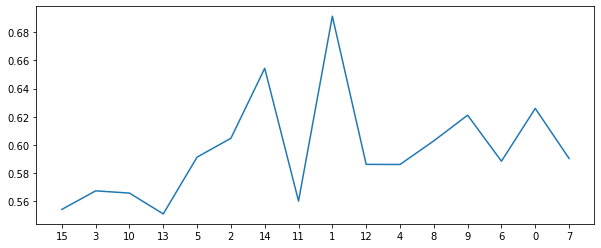

new features [10, 15, 3, 8, 13, 2, 11]
[0.4, 2, 1000, 4, 0.5, 0.75, 1.5, 3, 0.75, 0.2, 0.8]
accuracy     0.6142857142857143
specificity  0.6032805429864253
sensitivity  0.77
auc          0.6866402714932127


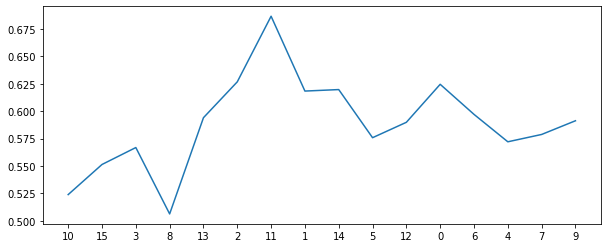

new features [8, 15, 10, 13, 3, 2, 1]
[0.4, 2, 1000, 4, 0.5, 0.75, 1.5, 3, 1.0, 0.2, 0.8]
accuracy     0.6375
specificity  0.6282051282051282
sensitivity  0.76
auc          0.6941025641025641


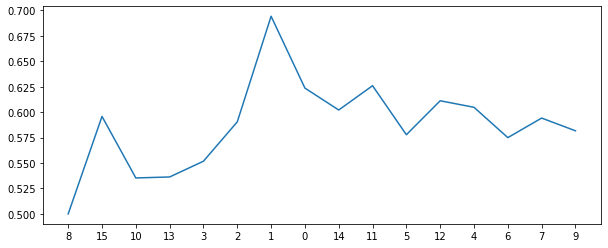

new features [15, 10, 2, 3, 1, 11, 8]
[0.4, 2, 1000, 4, 1, 1, 1.5, 5, 0.75, 0.2, 0.8]
accuracy     0.5767857142857142
specificity  0.5590497737556561
sensitivity  0.815
auc          0.687024886877828


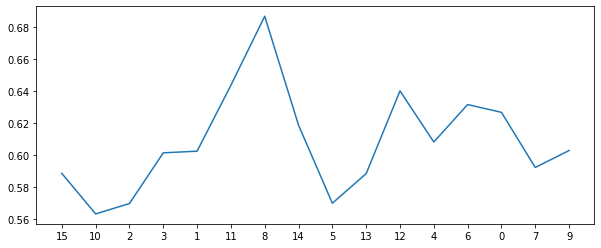

new features [9, 7, 13, 8, 15, 10, 3, 11, 12, 1, 14, 2]
[0.4, 3, 1000, 1, 0, 0.5, 1, 4, 0.5, 0.2, 1.0]
accuracy     0.6410714285714286
specificity  0.6340874811463046
sensitivity  0.735
auc          0.6845437405731524


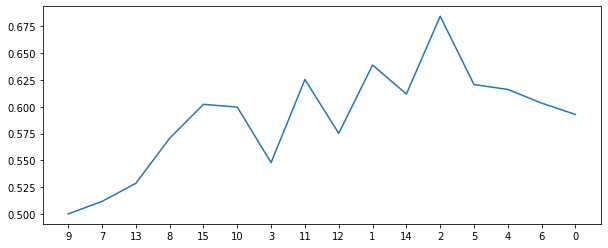

new features [9, 8, 13, 15, 3, 1, 10, 7, 14, 2, 5, 12, 11, 6, 4, 0]
[0.4, 3, 1000, 1, 0, 0.75, 1, 5, 1.0, 0.2, 0.8]
accuracy     0.6446428571428572
specificity  0.6380090497737556
sensitivity  0.74
auc          0.6890045248868778


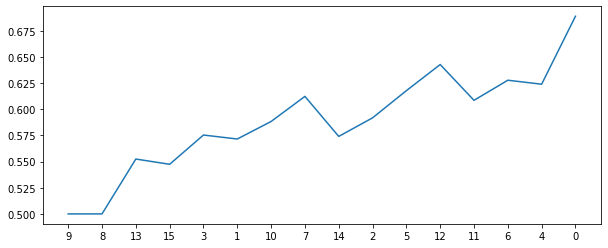

new features [7, 9, 15, 8, 1, 13]
[0.4, 3, 1000, 1, 0, 1, 1.5, 4, 0.75, 0.2, 1.0]
accuracy     0.6160714285714286
specificity  0.605052790346908
sensitivity  0.765
auc          0.685026395173454


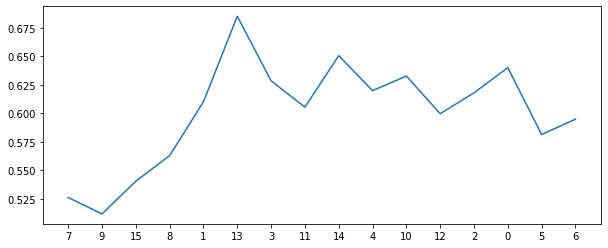

new features [7, 15, 8, 3, 13, 14, 10, 5, 2, 11, 1]
[0.4, 3, 1000, 1, 0.5, 0.75, 1.5, 5, 0.5, 0.2, 0.8]
accuracy     0.5875
specificity  0.5706259426847662
sensitivity  0.815
auc          0.6928129713423832


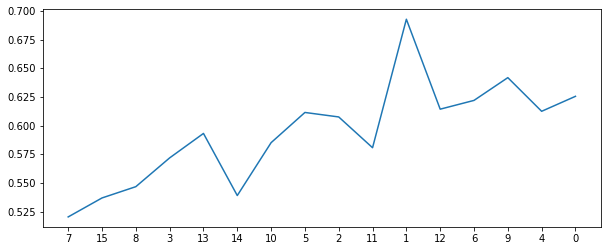

new features [15, 8, 3, 7, 13, 1]
[0.4, 3, 1000, 1, 1, 0.75, 1.5, 3, 1.0, 0.2, 1.0]
accuracy     0.6125
specificity  0.6013574660633484
sensitivity  0.765
auc          0.6831787330316742


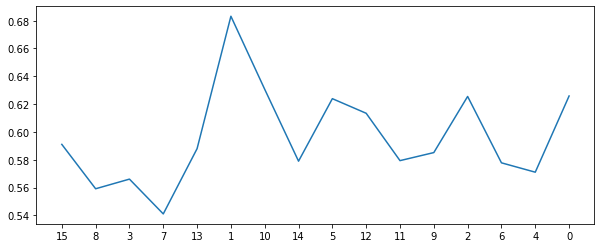

new features [15, 3, 7, 1, 2]
[0.4, 3, 1000, 1, 1, 0.75, 1.5, 4, 1.0, 0.2, 0.8]
accuracy     0.6071428571428571
specificity  0.5937405731523379
sensitivity  0.79
auc          0.691870286576169


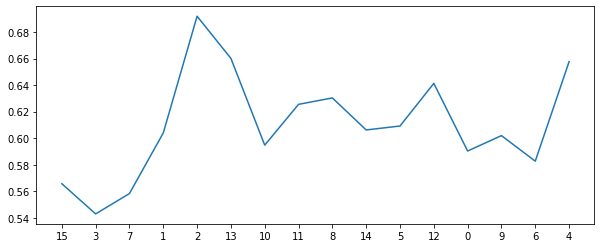

new features [10, 8, 15, 4, 13, 3, 1, 11, 14, 2, 5, 12]
[0.4, 3, 1000, 3, 0, 0.5, 1, 3, 0.75, 0.2, 1.0]
accuracy     0.6714285714285715
specificity  0.6707767722473605
sensitivity  0.69
auc          0.6803883861236802


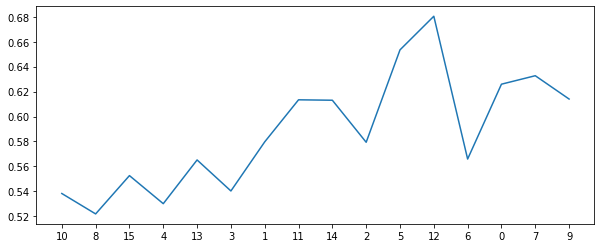

new features [8, 10, 15, 13, 3, 2, 4, 11]
[0.4, 3, 1000, 3, 0, 0.75, 1, 4, 0.5, 0.2, 1.0]
accuracy     0.6303571428571428
specificity  0.6206636500754148
sensitivity  0.76
auc          0.6903318250377074


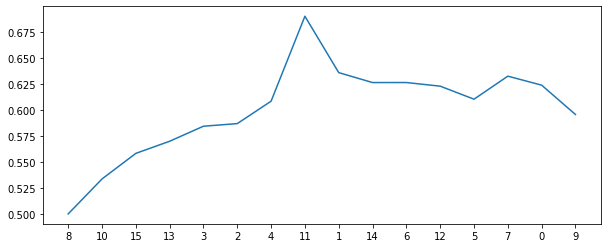

new features [10, 8, 13, 15, 3, 1, 11, 0, 14, 12, 5, 6, 2, 4, 7]
[0.4, 3, 1000, 3, 0, 0.75, 1.5, 3, 0.75, 0.2, 1.0]
accuracy     0.6553571428571429
specificity  0.6515837104072398
sensitivity  0.71
auc          0.68079185520362


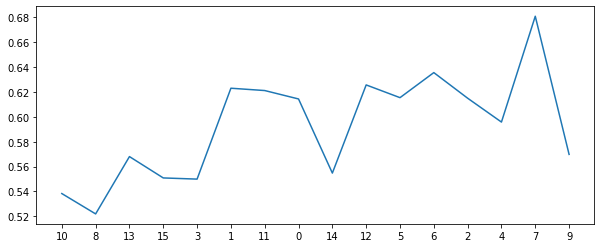

new features [8, 10, 15, 3, 2]
[0.4, 3, 1000, 3, 0, 1, 1, 5, 1.0, 0.2, 0.8]
accuracy     0.6107142857142858
specificity  0.59947209653092
sensitivity  0.765
auc          0.68223604826546


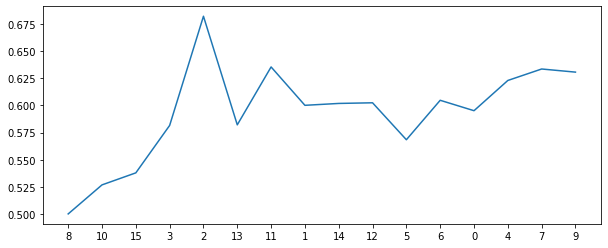

new features [8, 15, 3, 13, 10, 11, 2, 4]
[0.4, 3, 1000, 3, 0.5, 0.75, 1, 4, 0.5, 0.2, 1.0]
accuracy     0.5928571428571429
specificity  0.5782428355957767
sensitivity  0.785
auc          0.6816214177978883


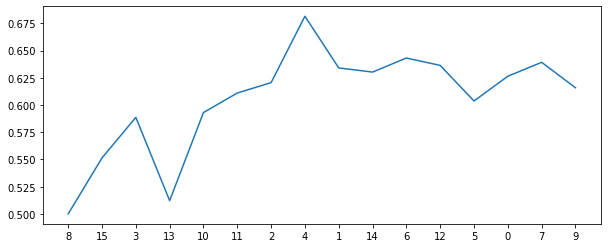

new features [15, 8, 2, 3, 1, 12]
[0.4, 3, 1000, 3, 0.5, 0.75, 1, 4, 1.0, 0.2, 1.0]
accuracy     0.5982142857142857
specificity  0.5840120663650076
sensitivity  0.79
auc          0.6870060331825038


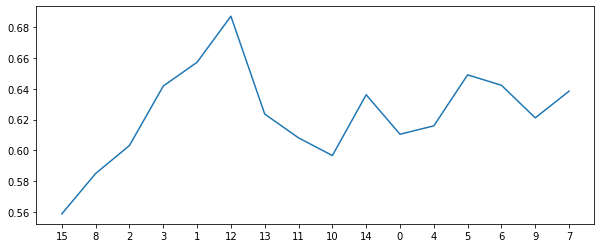

new features [8, 15, 3, 13, 10, 12, 1, 11, 14, 2, 0, 5, 6, 4]
[0.4, 3, 1000, 3, 1, 1, 1.5, 3, 0.75, 0.2, 1.0]
accuracy     0.6357142857142857
specificity  0.628393665158371
sensitivity  0.735
auc          0.6816968325791856


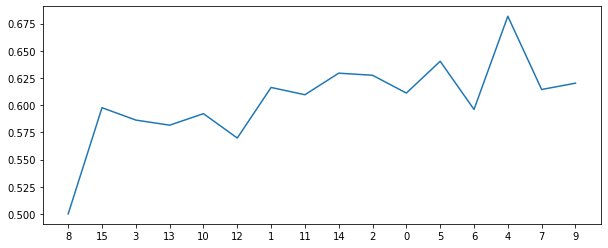

new features [8, 15, 10, 3, 2, 1]
[0.4, 3, 1000, 3, 1, 1, 2, 3, 0.75, 0.2, 0.8]
accuracy     0.6428571428571428
specificity  0.6360482654600301
sensitivity  0.74
auc          0.6880241327300152


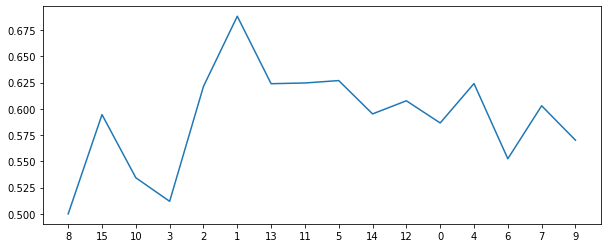

new features [15, 8, 3, 10, 6, 2, 1]
[0.4, 3, 1000, 4, 0, 1, 1.5, 4, 1.0, 0.2, 0.8]
accuracy     0.5946428571428571
specificity  0.5802790346907994
sensitivity  0.795
auc          0.6876395173453997


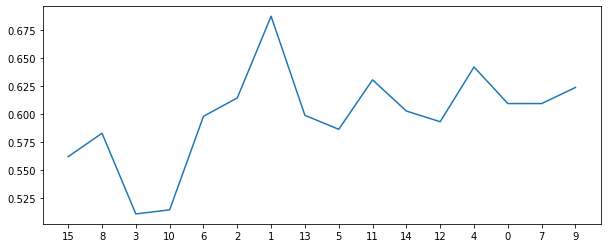

new features [10, 15, 8, 3, 11, 2, 13, 1]
[0.4, 3, 1000, 4, 1, 1, 1, 4, 0.75, 0.2, 0.8]
accuracy     0.5982142857142857
specificity  0.5840874811463047
sensitivity  0.785
auc          0.6845437405731524


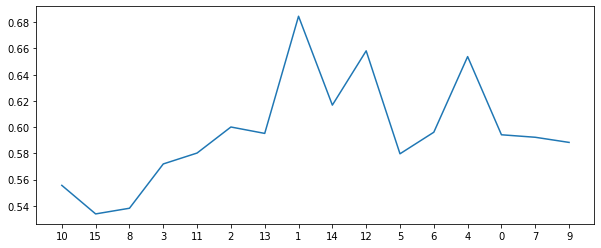

In [32]:
max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comb,MAX_feat,INDEXES,best_params_total= gridsearch(params)

In [33]:
print(MAX_feat)
print(MAX_comb)
print(MAX_acc)
print(MAX_spec)
print(MAX_sens)
print(MAX_auc)

[15, 7, 3, 2, 8]
[0.4, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0.2, 0.8]
0.6553571428571429
0.6475490196078432
0.77
0.7087745098039215


In [34]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params_total)):
    if best_params_total[i][4] > 0.69:
        print("parameters :",best_params_total[i][0])
        print("accuracy :",best_params_total[i][1])
        print("spes     :",best_params_total[i][2])
        print("sens     :",best_params_total[i][3])
        print("auc      :",best_params_total[i][4])
        print(best_params_total[i][5])
        print(best_params_total[i][6])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.4, 2, 1000, 1, 0, 0.5, 1.5, 5, 1.0, 0.2, 0.8]
accuracy : 0.6017857142857143
spes     : 0.5861236802413273
sens     : 0.81
auc      : 0.6980618401206636
[7, 3, 15, 13, 8, 10, 5, 11, 1, 2, 14, 12, 6, 9]
[7, 3, 15, 13, 8, 10, 5, 11, 1, 2, 14, 12, 6, 9, 0, 4, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0.2, 0.8]
accuracy : 0.6553571428571429
spes     : 0.6475490196078432
sens     : 0.77
auc      : 0.7087745098039215
[15, 7, 3, 2, 8]
[15, 7, 3, 2, 8, 10, 13, 1, 11, 5, 12, 14, 4, 9, 6, 0, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 2, 1, 0.5, 1.5, 3, 0.5, 0.2, 0.8]
accuracy : 0.6321428571428571
spes     : 0.6225867269984917
sens     : 0.76
auc      : 0.6912933634992459
[15, 3, 10, 13, 5, 2, 14, 11, 1]
[15, 3, 10, 13, 5, 2, 14, 11, 1, 12, 4, 8, 9, 6, 0, 7, 16]
------------------------------------------------
parameters : [0.4, 2, 1000, 4, 0.5, 0.75, 1.5, 3, 1.0, 0.2, 0.8]
accuracy :

In [35]:
IND = []
for i in range(len(INDEXES)):
    IND.append(INDEXES[i]//min(INDEXES))
print(IND)

[1, 2, 2, 3, 1, 1, 1, 1, 3, 1, 3, 2, 1, 3, 2, 4]


In [20]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.5],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2,3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1,2,3,4],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0,0.5,1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5,0.75,1], #0.5-1
                     "reg_lambda"      :[1, 1.5, 2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3,4,5],
                    "colsample_bytree" :[0.5,0.75,1.0],
                    "reg_alpha"        :[0],
                    "subsample"        :[0.8,1.0]
    
        }

3888
new features [3, 15, 7, 2, 11, 9, 8]
[0.5, 2, 1000, 1, 0.5, 0.5, 1, 3, 1.0, 0, 0.8]
accuracy     0.65
specificity  0.6455505279034691
sensitivity  0.715
auc          0.6802752639517345


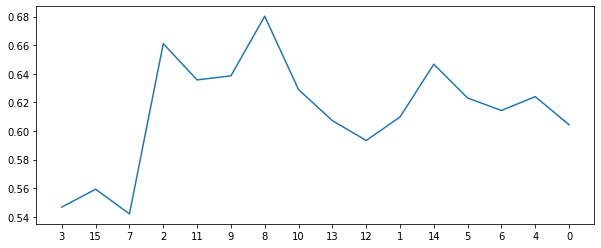

new features [3, 15, 8, 2]
[0.5, 2, 1000, 1, 1, 0.5, 1, 4, 1.0, 0, 0.8]
accuracy     0.5928571428571429
specificity  0.5780920060331824
sensitivity  0.79
auc          0.6840460030165912


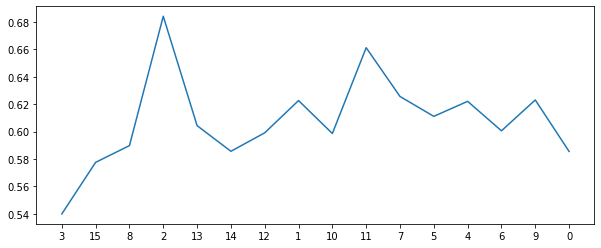

new features [15, 13, 8, 3, 10, 11, 14, 2, 1]
[0.5, 2, 1000, 2, 0, 0.5, 2, 3, 0.5, 0, 1.0]
accuracy     0.65
specificity  0.6437782805429865
sensitivity  0.74
auc          0.6918891402714932


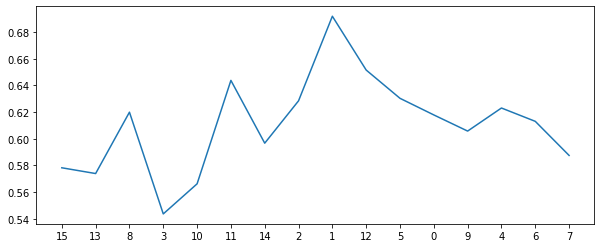

new features [7, 9, 15, 3, 13, 10, 11, 8, 12, 5, 1, 14, 6, 2, 0]
[0.5, 2, 1000, 2, 0, 0.75, 1, 5, 1.0, 0, 1.0]
accuracy     0.6089285714285715
specificity  0.5955882352941176
sensitivity  0.785
auc          0.6902941176470588


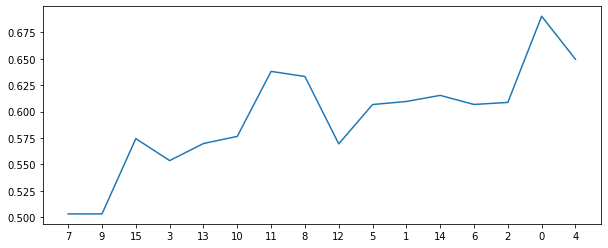

new features [15, 3, 1, 8, 13, 10, 11, 14, 2, 9, 5, 12, 6]
[0.5, 2, 1000, 2, 1, 1, 1.5, 5, 0.75, 0, 1.0]
accuracy     0.5571428571428572
specificity  0.5360859728506787
sensitivity  0.835
auc          0.6855429864253394


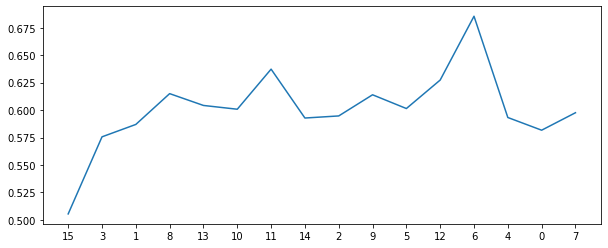

new features [8, 10, 15, 11, 1, 13, 3, 0, 14, 2, 5, 6, 12, 4]
[0.5, 2, 1000, 3, 0, 0.75, 1, 5, 0.75, 0, 1.0]
accuracy     0.5875
specificity  0.5706636500754148
sensitivity  0.81
auc          0.6903318250377074


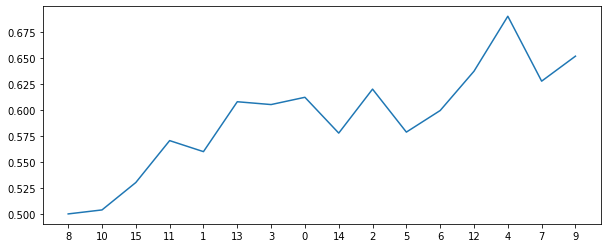

new features [8, 15, 3, 10, 13, 2, 1, 5, 14, 11, 12, 6]
[0.5, 2, 1000, 3, 0, 0.75, 1.5, 5, 1.0, 0, 0.8]
accuracy     0.6160714285714286
specificity  0.6052790346907994
sensitivity  0.76
auc          0.6826395173453997


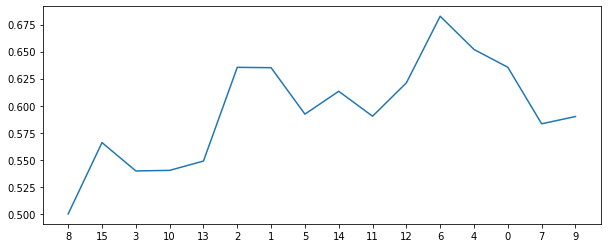

new features [15, 3, 10, 2, 1, 13, 5, 12, 11, 14, 8, 4, 6, 0]
[0.5, 2, 1000, 3, 0.5, 0.5, 2, 4, 1.0, 0, 0.8]
accuracy     0.6214285714285714
specificity  0.6110482654600302
sensitivity  0.76
auc          0.6855241327300151


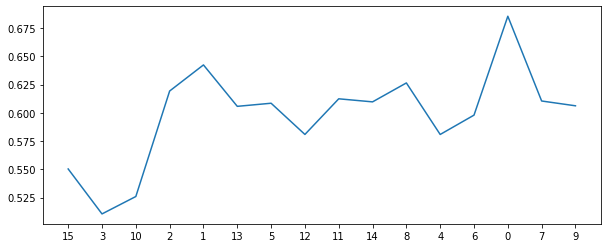

new features [10, 15, 3, 13, 11, 8, 14, 1, 2]
[0.5, 2, 1000, 3, 0.5, 0.75, 1, 3, 0.75, 0, 1.0]
accuracy     0.6571428571428571
specificity  0.6533182503770739
sensitivity  0.71
auc          0.681659125188537


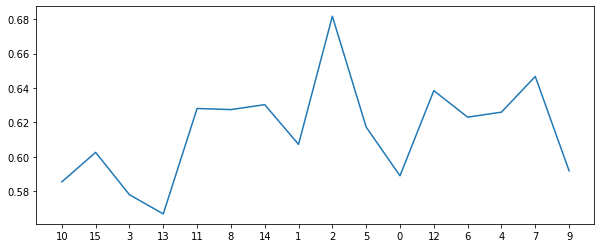

new features [10, 15, 8, 13, 3, 1, 5, 11, 2, 12, 14, 6]
[0.5, 2, 1000, 3, 0.5, 0.75, 1.5, 4, 1.0, 0, 0.8]
accuracy     0.6178571428571429
specificity  0.6072398190045248
sensitivity  0.76
auc          0.6836199095022625


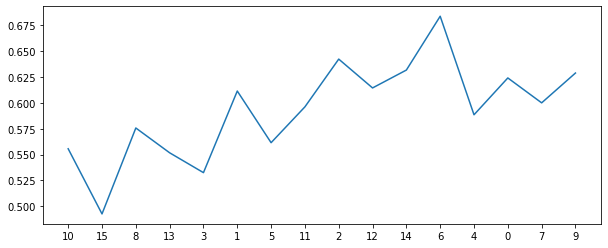

new features [10, 8, 3, 11, 13, 15, 2]
[0.5, 2, 1000, 3, 1, 0.5, 1.5, 3, 0.75, 0, 0.8]
accuracy     0.6357142857142857
specificity  0.6282428355957768
sensitivity  0.735
auc          0.6816214177978883


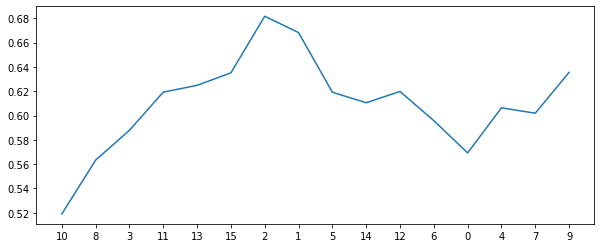

new features [8, 10, 15, 3, 11, 4, 13, 2]
[0.5, 2, 1000, 4, 0, 0.75, 1.5, 3, 0.5, 0, 1.0]
accuracy     0.6321428571428571
specificity  0.6245098039215686
sensitivity  0.74
auc          0.6822549019607843


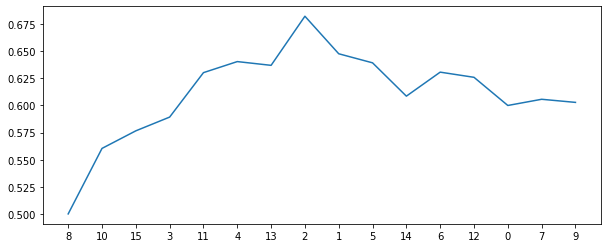

new features [15, 10, 3, 13, 11, 8, 12, 14, 1, 6, 2]
[0.5, 2, 1000, 4, 0.5, 0.5, 2, 3, 0.5, 0, 1.0]
accuracy     0.6035714285714285
specificity  0.589894419306184
sensitivity  0.785
auc          0.6874472096530919


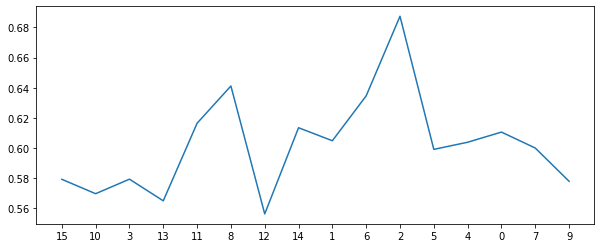

new features [10, 9, 13, 15, 8, 1, 3, 14, 11]
[0.5, 3, 1000, 1, 0, 0.5, 1.5, 5, 0.75, 0, 1.0]
accuracy     0.6285714285714286
specificity  0.6205505279034691
sensitivity  0.74
auc          0.6802752639517344


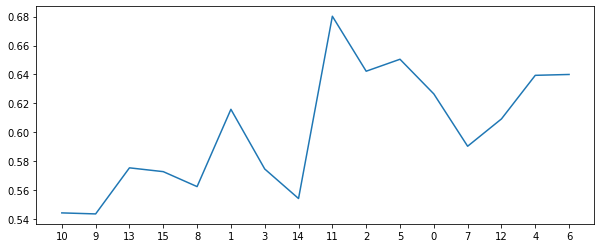

new features [9, 10, 13, 8, 15, 1, 3, 11, 2, 14]
[0.5, 3, 1000, 1, 0, 0.5, 2, 5, 0.75, 0, 1.0]
accuracy     0.5910714285714286
specificity  0.5762066365007541
sensitivity  0.785
auc          0.680603318250377


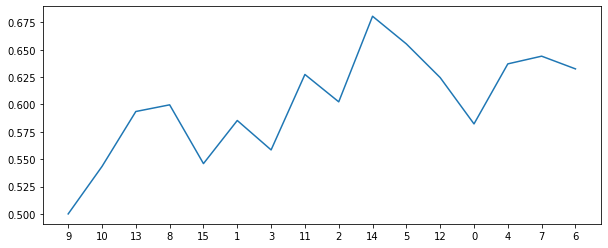

new features [9, 8, 13, 15, 4, 3, 7, 10, 11, 2, 1, 14]
[0.5, 3, 1000, 1, 0, 0.75, 1.5, 3, 0.5, 0, 1.0]
accuracy     0.6767857142857143
specificity  0.6765082956259427
sensitivity  0.685
auc          0.6807541478129714


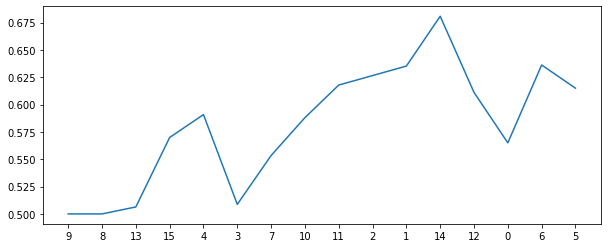

new features [8, 7, 15, 1, 3, 2]
[0.5, 3, 1000, 1, 0, 0.75, 1.5, 4, 1.0, 0, 0.8]
accuracy     0.6464285714285715
specificity  0.6397812971342383
sensitivity  0.74
auc          0.6898906485671191


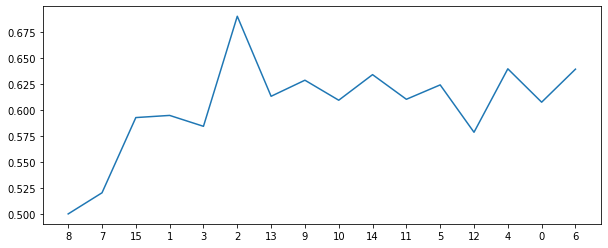

new features [8, 10, 15, 5, 1, 3, 14, 13, 11, 2, 4, 9, 12, 7]
[0.5, 3, 1000, 1, 0.5, 0.5, 2, 5, 0.75, 0, 0.8]
accuracy     0.6178571428571429
specificity  0.6072021116138763
sensitivity  0.76
auc          0.6836010558069382


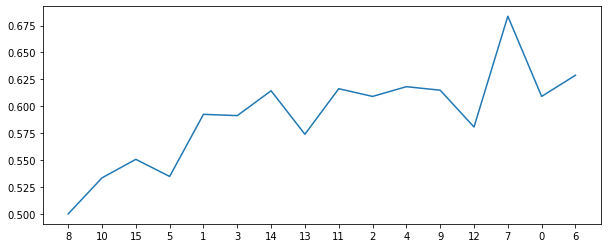

new features [8, 15, 14, 3, 1, 10, 13, 5, 2, 9, 11]
[0.5, 3, 1000, 1, 0.5, 0.75, 1, 4, 0.5, 0, 0.8]
accuracy     0.6303571428571428
specificity  0.6207013574660634
sensitivity  0.765
auc          0.6928506787330316


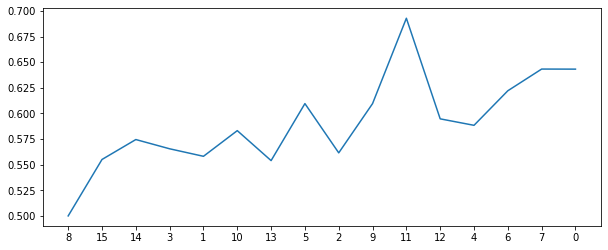

new features [1, 3, 15, 8, 13]
[0.5, 3, 1000, 1, 1, 0.75, 2, 3, 0.75, 0, 1.0]
accuracy     0.6392857142857142
specificity  0.6322021116138763
sensitivity  0.74
auc          0.6861010558069381


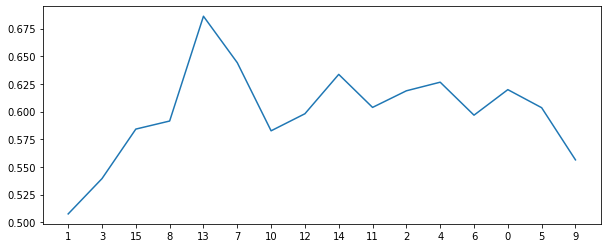

new features [15, 3, 2, 10, 8, 14, 13, 5]
[0.5, 3, 1000, 2, 0, 0.5, 2, 4, 0.5, 0, 0.8]
accuracy     0.6410714285714285
specificity  0.6340874811463046
sensitivity  0.735
auc          0.6845437405731524


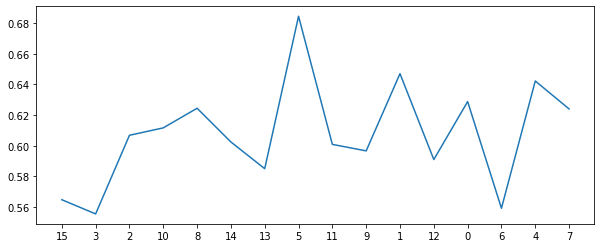

new features [9, 10, 15, 8, 1, 3, 13, 4, 7, 14, 2, 12, 11, 6, 5]
[0.5, 3, 1000, 2, 0, 0.5, 2, 5, 0.75, 0, 1.0]
accuracy     0.5732142857142857
specificity  0.5553544494720966
sensitivity  0.81
auc          0.6826772247360483


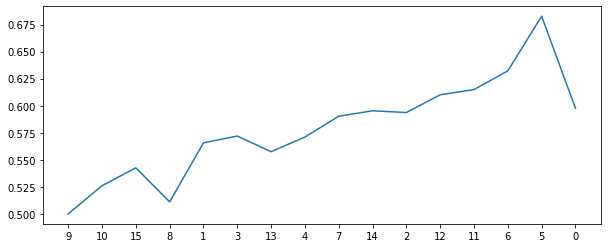

new features [13, 8, 10, 15, 3, 1, 11, 9, 14, 2, 12, 4, 5, 0]
[0.5, 3, 1000, 2, 0.5, 0.75, 2, 4, 0.75, 0, 1.0]
accuracy     0.5982142857142857
specificity  0.5841628959276018
sensitivity  0.79
auc          0.6870814479638009


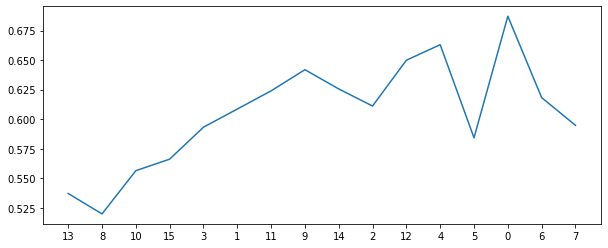

new features [15, 8, 3, 2, 5, 10, 1, 12]
[0.5, 3, 1000, 3, 0, 0.5, 1.5, 4, 1.0, 0, 0.8]
accuracy     0.6321428571428571
specificity  0.6226244343891403
sensitivity  0.765
auc          0.6938122171945701


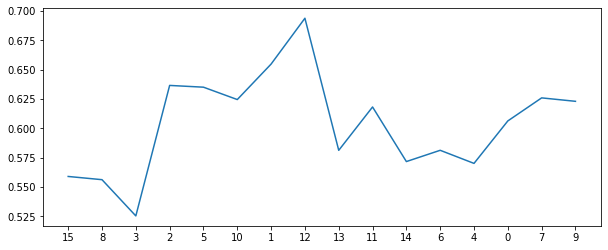

new features [8, 15, 10, 3, 2, 13, 14, 11, 12]
[0.5, 3, 1000, 3, 0, 0.5, 1.5, 5, 0.5, 0, 0.8]
accuracy     0.6053571428571428
specificity  0.5917797888386124
sensitivity  0.785
auc          0.6883898944193062


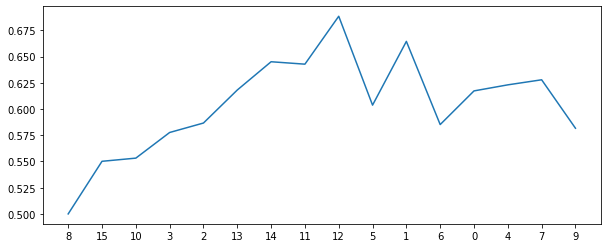

new features [15, 3, 8, 10, 9, 2, 11]
[0.5, 3, 1000, 3, 0.5, 0.5, 1, 4, 0.5, 0, 0.8]
accuracy     0.6089285714285715
specificity  0.5955128205128205
sensitivity  0.79
auc          0.6927564102564102


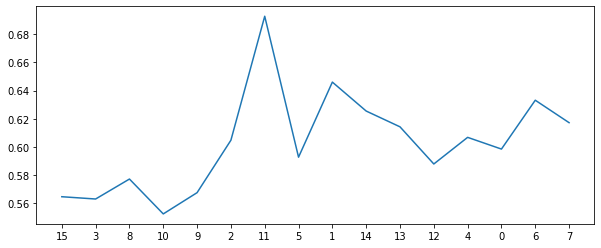

new features [10, 15, 8, 3, 1, 13, 5, 11, 14, 2, 0, 12, 4, 6, 9, 7]
[0.5, 3, 1000, 3, 0.5, 0.5, 2, 5, 0.75, 0, 0.8]
accuracy     0.5982142857142857
specificity  0.5840120663650076
sensitivity  0.785
auc          0.6845060331825038


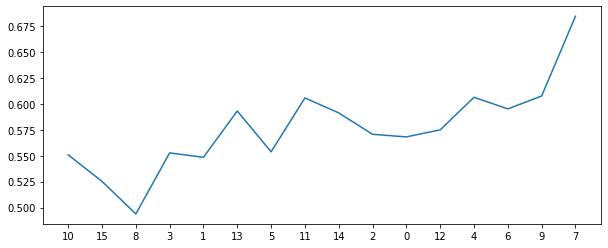

new features [8, 10, 15, 3, 2, 1]
[0.5, 3, 1000, 3, 0.5, 1, 2, 5, 0.75, 0, 0.8]
accuracy     0.5875
specificity  0.5725490196078431
sensitivity  0.79
auc          0.6812745098039216


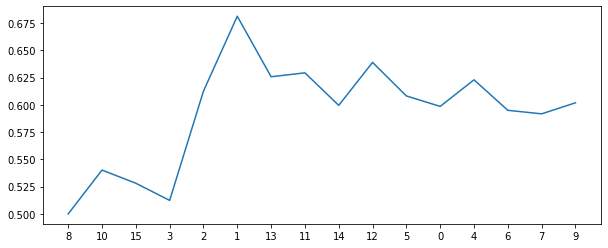

new features [8, 15, 3, 13, 10, 11, 14, 4, 2]
[0.5, 3, 1000, 4, 0.5, 0.75, 2, 5, 0.5, 0, 1.0]
accuracy     0.5482142857142858
specificity  0.5263197586726999
sensitivity  0.835
auc          0.68065987933635


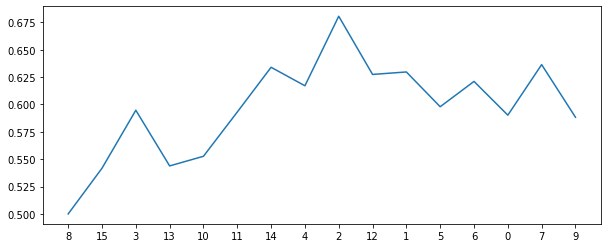

new features [15, 2, 8, 3, 10, 13, 11, 1]
[0.5, 3, 1000, 4, 1, 1, 1.5, 4, 0.75, 0, 1.0]
accuracy     0.5910714285714286
specificity  0.5762443438914027
sensitivity  0.785
auc          0.6806221719457013


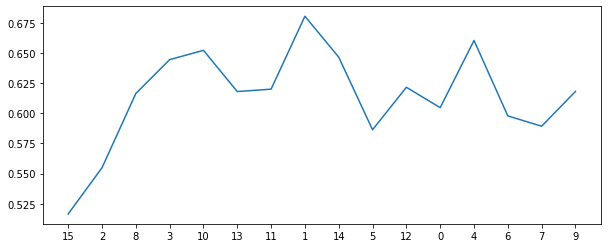

In [21]:
max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comb,MAX_feat,INDEXES,best_params_total= gridsearch(params)

In [22]:
print(MAX_feat)
print(MAX_comb)
print(MAX_acc)
print(MAX_spec)
print(MAX_sens)
print(MAX_auc)

[15, 8, 3, 2, 5, 10, 1, 12]
[0.5, 3, 1000, 3, 0, 0.5, 1.5, 4, 1.0, 0, 0.8]
0.6321428571428571
0.6226244343891403
0.765
0.6938122171945701


In [23]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params_total)):
    if best_params_total[i][4] > 0.69:
        print("parameters :",best_params_total[i][0])
        print("accuracy :",best_params_total[i][1])
        print("spes     :",best_params_total[i][2])
        print("sens     :",best_params_total[i][3])
        print("auc      :",best_params_total[i][4])
        print(best_params_total[i][5])
        print(best_params_total[i][6])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.5, 2, 1000, 2, 0, 0.5, 2, 3, 0.5, 0, 1.0]
accuracy : 0.65
spes     : 0.6437782805429865
sens     : 0.74
auc      : 0.6918891402714932
[15, 13, 8, 3, 10, 11, 14, 2, 1]
[15, 13, 8, 3, 10, 11, 14, 2, 1, 12, 5, 0, 9, 4, 6, 7, 16]
------------------------------------------------
parameters : [0.5, 2, 1000, 2, 0, 0.75, 1, 5, 1.0, 0, 1.0]
accuracy : 0.6089285714285715
spes     : 0.5955882352941176
sens     : 0.785
auc      : 0.6902941176470588
[7, 9, 15, 3, 13, 10, 11, 8, 12, 5, 1, 14, 6, 2, 0]
[7, 9, 15, 3, 13, 10, 11, 8, 12, 5, 1, 14, 6, 2, 0, 4, 16]
------------------------------------------------
parameters : [0.5, 2, 1000, 3, 0, 0.75, 1, 5, 0.75, 0, 1.0]
accuracy : 0.5875
spes     : 0.5706636500754148
sens     : 0.81
auc      : 0.6903318250377074
[8, 10, 15, 11, 1, 13, 3, 0, 14, 2, 5, 6, 12, 4]
[8, 10, 15, 11, 1, 13, 3, 0, 14, 2, 5, 6, 12, 4, 7, 9, 16]
------------------------------------------------
parameters : [0.5, 3, 1000, 1, 0.5, 0.75, 1, 4, 0.5, 0, 0.8]
accuracy : 

In [24]:
IND = []
for i in range(len(INDEXES)):
    IND.append(INDEXES[i]//min(INDEXES))
print(IND)

[1, 2, 2, 3, 1, 2, 1, 1, 3, 1, 3, 2, 1, 3, 2, 3]


In [20]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.5],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2,3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1,2,3,4],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0,0.5,1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5,0.75,1], #0.5-1
                     "reg_lambda"      :[1, 1.5, 2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3,4,5],
                    "colsample_bytree" :[0.5,0.75,1.0],
                    "reg_alpha"        :[0.1],
                    "subsample"        :[0.8,1.0]
    
        }

3888
new features [7, 15, 3, 13, 12, 8, 1, 5, 14, 10, 11, 2, 6, 4, 0]
[0.5, 2, 1000, 1, 0.5, 0.5, 1, 4, 1.0, 0.1, 1.0]
accuracy     0.6196428571428572
specificity  0.6091251885369533
sensitivity  0.76
auc          0.6845625942684767


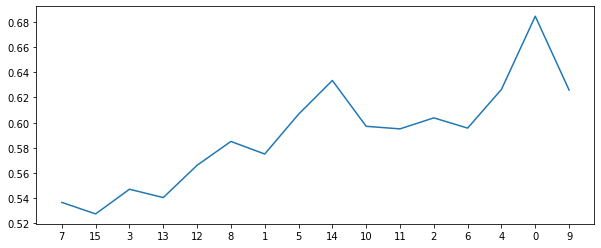

new features [15, 10, 3, 13, 4, 11]
[0.5, 2, 1000, 1, 1, 0.5, 1.5, 3, 0.5, 0.1, 1.0]
accuracy     0.5946428571428571
specificity  0.5803544494720965
sensitivity  0.79
auc          0.6851772247360483


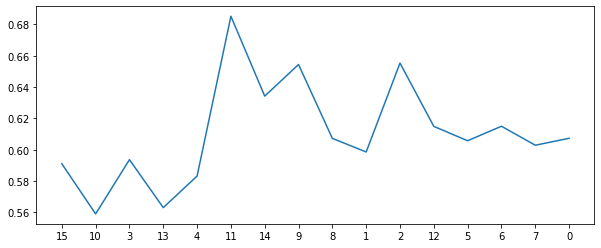

new features [15, 3, 1, 10, 8, 2, 14]
[0.5, 2, 1000, 1, 1, 0.75, 1, 5, 0.75, 0.1, 0.8]
accuracy     0.6017857142857143
specificity  0.5878582202111614
sensitivity  0.79
auc          0.6889291101055807


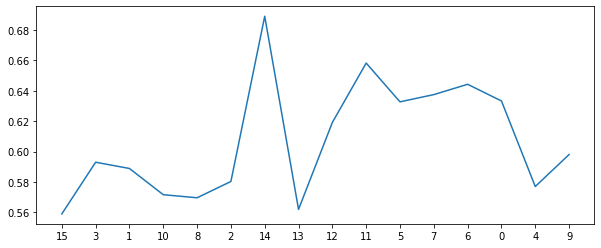

new features [8, 10, 3, 1, 15, 13, 5, 11, 14, 2, 12, 6, 4, 0, 9, 7]
[0.5, 2, 1000, 2, 0, 0.5, 1, 5, 0.75, 0.1, 0.8]
accuracy     0.5857142857142857
specificity  0.5686651583710407
sensitivity  0.81
auc          0.6893325791855204


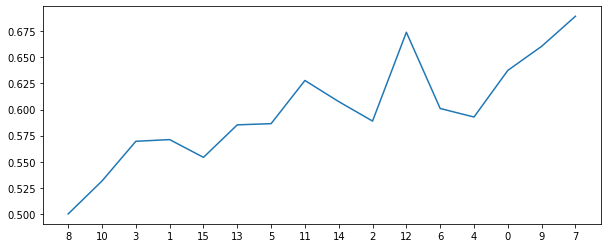

new features [15, 3, 2, 8, 11, 10, 13, 9, 14]
[0.5, 2, 1000, 2, 0, 0.5, 2, 3, 0.5, 0.1, 0.8]
accuracy     0.6339285714285714
specificity  0.6265460030165912
sensitivity  0.74
auc          0.6832730015082956


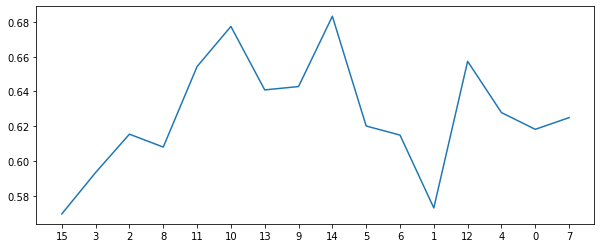

new features [13, 15, 10, 3, 8, 11, 1, 14, 2, 12, 4, 5]
[0.5, 2, 1000, 2, 0.5, 0.5, 1.5, 4, 0.5, 0.1, 1.0]
accuracy     0.6071428571428571
specificity  0.5937405731523379
sensitivity  0.785
auc          0.689370286576169


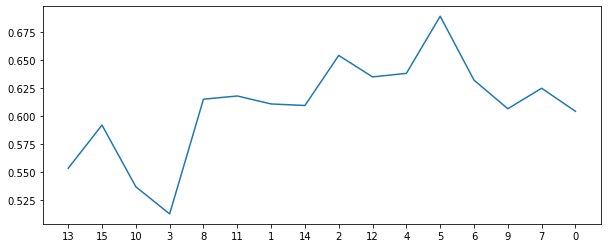

new features [8, 15, 13, 3, 10, 11, 14, 2, 12]
[0.5, 2, 1000, 2, 1, 0.75, 1, 3, 0.5, 0.1, 1.0]
accuracy     0.6321428571428571
specificity  0.6245098039215686
sensitivity  0.74
auc          0.6822549019607843


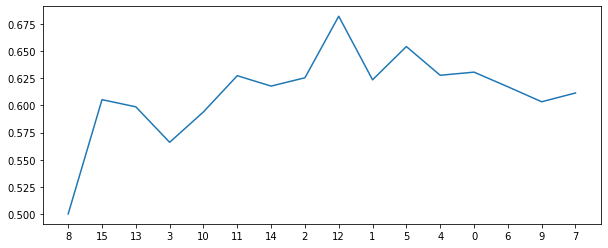

new features [10, 8, 15, 1, 5, 11, 3]
[0.5, 2, 1000, 3, 0, 0.5, 1, 3, 0.75, 0.1, 1.0]
accuracy     0.6517857142857143
specificity  0.645739064856712
sensitivity  0.73
auc          0.6878695324283559


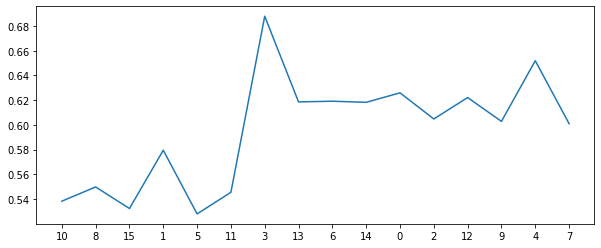

new features [8, 15, 10, 3, 1, 13, 11, 4, 12, 2, 14]
[0.5, 2, 1000, 3, 0, 0.5, 2, 5, 1.0, 0.1, 1.0]
accuracy     0.5875
specificity  0.5725490196078431
sensitivity  0.79
auc          0.6812745098039216


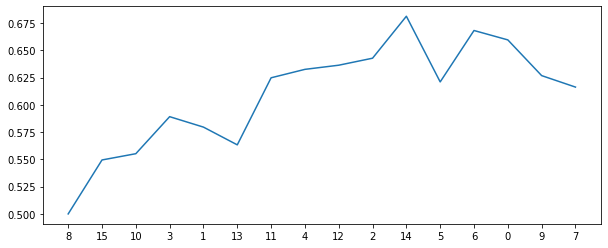

new features [15, 8, 10, 1, 3, 13, 11, 6, 12, 14, 5, 2, 4, 0, 7]
[0.5, 2, 1000, 3, 0, 0.75, 2, 3, 1.0, 0.1, 1.0]
accuracy     0.6553571428571429
specificity  0.6514328808446456
sensitivity  0.71
auc          0.6807164404223227


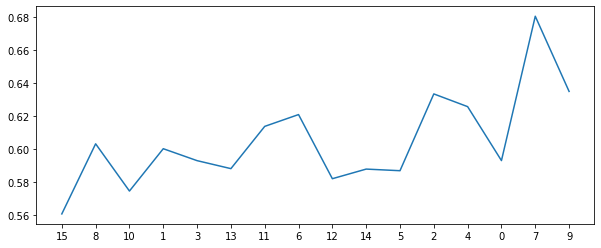

new features [8, 10, 15, 1, 3, 2, 11]
[0.5, 2, 1000, 3, 0, 1, 2, 5, 0.5, 0.1, 1.0]
accuracy     0.5839285714285715
specificity  0.5687028657616893
sensitivity  0.795
auc          0.6818514328808446


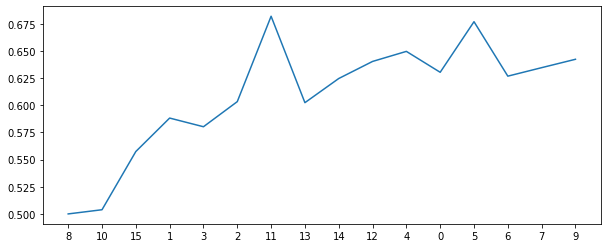

new features [15, 8, 3, 2, 11]
[0.5, 2, 1000, 4, 0, 0.5, 1.5, 3, 0.5, 0.1, 0.8]
accuracy     0.6303571428571428
specificity  0.620475113122172
sensitivity  0.765
auc          0.6927375565610859


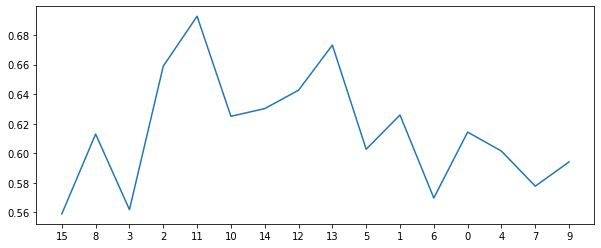

new features [8, 15, 3, 5, 2]
[0.5, 2, 1000, 4, 0, 0.5, 1.5, 3, 1.0, 0.1, 0.8]
accuracy     0.6375
specificity  0.630316742081448
sensitivity  0.735
auc          0.682658371040724


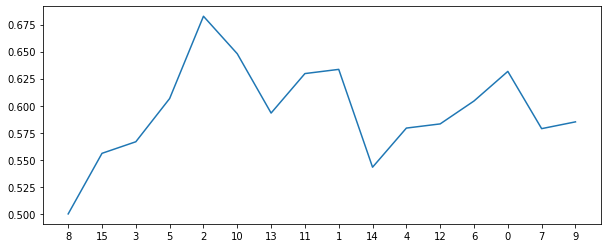

new features [8, 10, 15, 13, 3, 2, 11, 1, 14, 12]
[0.5, 2, 1000, 4, 0, 0.75, 1, 5, 0.5, 0.1, 1.0]
accuracy     0.5696428571428571
specificity  0.551395173453997
sensitivity  0.815
auc          0.6831975867269985


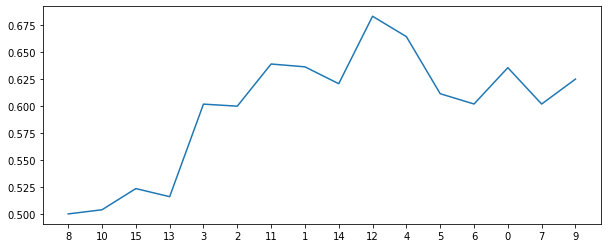

new features [8, 10, 15, 11, 4, 3, 1, 13, 2]
[0.5, 2, 1000, 4, 0, 1, 1, 4, 0.5, 0.1, 1.0]
accuracy     0.6125
specificity  0.6014705882352941
sensitivity  0.765
auc          0.683235294117647


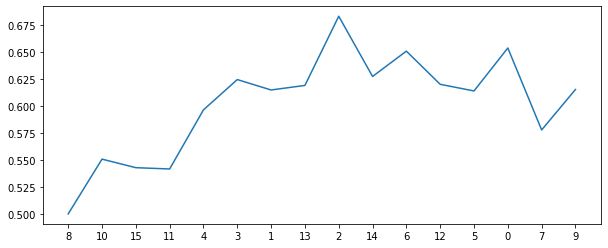

new features [10, 15, 8, 3, 11, 13, 4, 14, 2, 1]
[0.5, 2, 1000, 4, 0.5, 0.75, 1, 3, 0.5, 0.1, 1.0]
accuracy     0.6357142857142857
specificity  0.6283559577677225
sensitivity  0.735
auc          0.6816779788838613


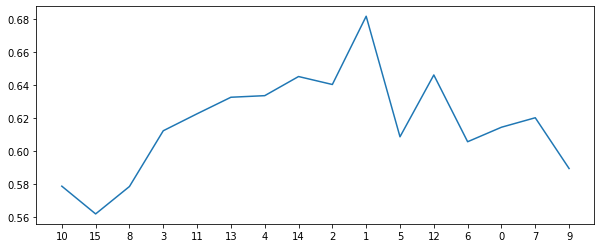

new features [15, 8, 10, 3, 13, 4, 5, 2, 11]
[0.5, 2, 1000, 4, 0.5, 0.75, 1.5, 3, 0.5, 0.1, 0.8]
accuracy     0.6410714285714285
specificity  0.6340497737556561
sensitivity  0.735
auc          0.6845248868778281


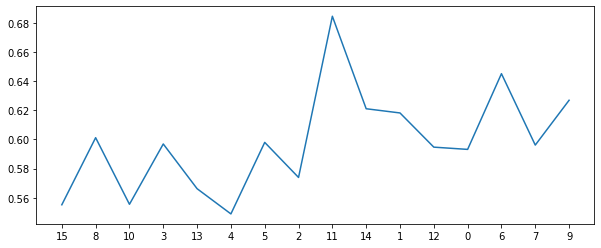

new features [8, 10, 3, 15, 1, 2, 11, 5]
[0.5, 2, 1000, 4, 1, 0.5, 1.5, 5, 0.75, 0.1, 0.8]
accuracy     0.5732142857142857
specificity  0.5532051282051282
sensitivity  0.835
auc          0.6941025641025641


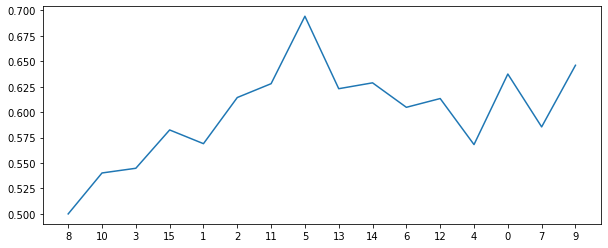

new features [9, 7, 13, 8, 15, 10, 3, 11, 12, 1, 2, 14]
[0.5, 3, 1000, 1, 0, 0.5, 1.5, 4, 0.5, 0.1, 1.0]
accuracy     0.6375
specificity  0.6283559577677225
sensitivity  0.76
auc          0.6941779788838612


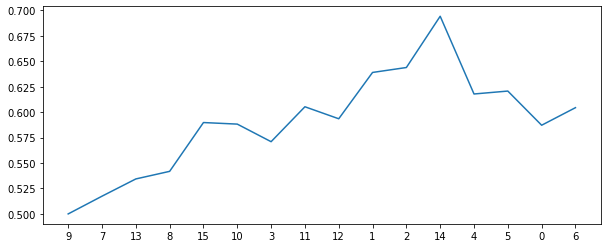

new features [7, 15, 9, 3, 8, 1, 2, 10]
[0.5, 3, 1000, 1, 0, 0.5, 2, 4, 1.0, 0.1, 0.8]
accuracy     0.6535714285714286
specificity  0.6495098039215687
sensitivity  0.715
auc          0.6822549019607843


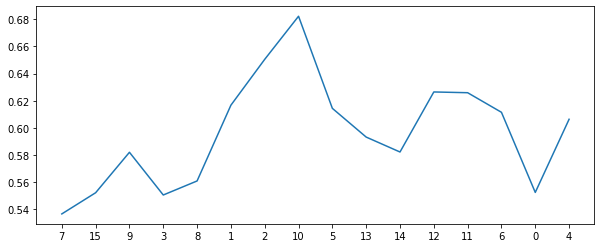

new features [8, 7, 15, 3, 1, 13, 5, 10, 14, 2, 12, 11, 9, 0, 4]
[0.5, 3, 1000, 1, 0, 0.5, 2, 5, 1.0, 0.1, 0.8]
accuracy     0.6339285714285714
specificity  0.6246229260935143
sensitivity  0.76
auc          0.6923114630467572


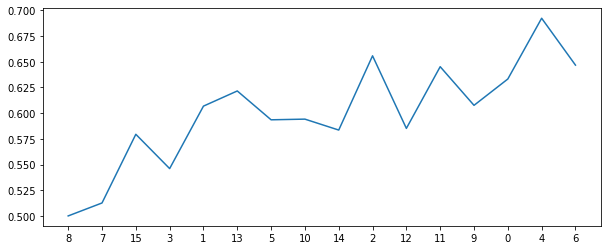

new features [8, 9, 13, 15, 10, 3, 2, 11, 1, 7, 14, 4]
[0.5, 3, 1000, 1, 0, 0.75, 1, 3, 0.5, 0.1, 1.0]
accuracy     0.6660714285714285
specificity  0.6630467571644042
sensitivity  0.71
auc          0.6865233785822021


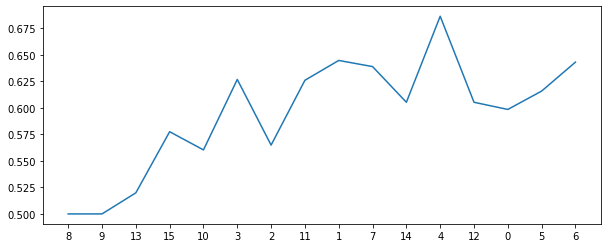

new features [8, 9, 15, 14, 10, 3, 1, 11, 2, 13, 5]
[0.5, 3, 1000, 1, 0, 0.75, 1, 4, 0.5, 0.1, 0.8]
accuracy     0.6321428571428571
specificity  0.6245098039215686
sensitivity  0.74
auc          0.6822549019607843


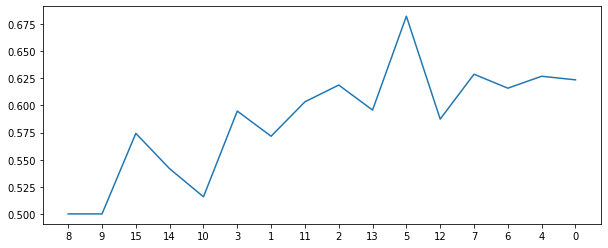

new features [15, 8, 7, 5, 1, 10, 3, 9, 12]
[0.5, 3, 1000, 1, 0.5, 0.75, 1.5, 3, 1.0, 0.1, 1.0]
accuracy     0.6785714285714286
specificity  0.6766968325791856
sensitivity  0.705
auc          0.6908484162895927


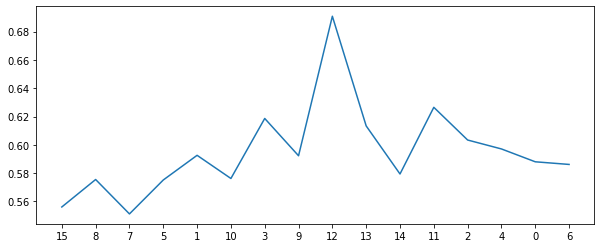

new features [8, 13, 15, 3, 0, 14, 10, 1, 11, 2, 4, 9]
[0.5, 3, 1000, 1, 0.5, 0.75, 2, 4, 0.5, 0.1, 1.0]
accuracy     0.6107142857142858
specificity  0.5975113122171946
sensitivity  0.785
auc          0.6912556561085973


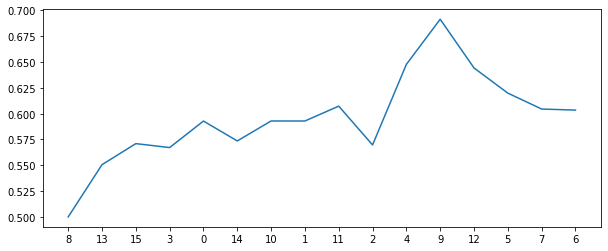

new features [15, 3, 13, 8, 1, 7, 10, 11]
[0.5, 3, 1000, 1, 0.5, 1, 1, 3, 0.75, 0.1, 1.0]
accuracy     0.6625
specificity  0.6590497737556561
sensitivity  0.715
auc          0.687024886877828


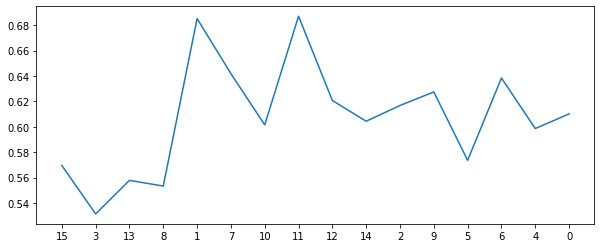

new features [7, 15, 1, 3, 8, 13]
[0.5, 3, 1000, 1, 0.5, 1, 1, 4, 1.0, 0.1, 1.0]
accuracy     0.6017857142857143
specificity  0.5877828054298643
sensitivity  0.785
auc          0.6863914027149322


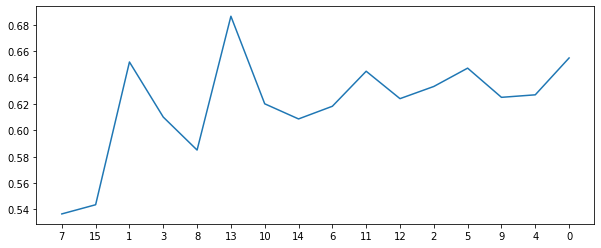

new features [8, 15, 1, 7, 10, 5, 3, 13, 11, 2, 9, 14, 12, 6]
[0.5, 3, 1000, 1, 0.5, 1, 1, 5, 0.75, 0.1, 0.8]
accuracy     0.6125
specificity  0.6014705882352941
sensitivity  0.76
auc          0.6807352941176471


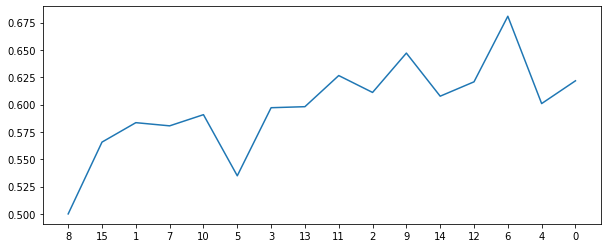

new features [15, 3, 8, 1, 2, 13]
[0.5, 3, 1000, 1, 1, 0.5, 1.5, 5, 0.5, 0.1, 0.8]
accuracy     0.5642857142857143
specificity  0.5452488687782805
sensitivity  0.815
auc          0.6801244343891403


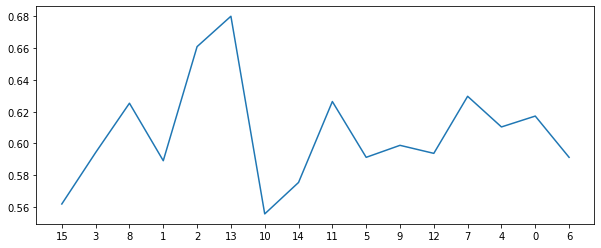

new features [8, 15, 1, 3, 13]
[0.5, 3, 1000, 1, 1, 0.75, 2, 3, 0.75, 0.1, 1.0]
accuracy     0.6196428571428572
specificity  0.6090874811463046
sensitivity  0.765
auc          0.6870437405731523


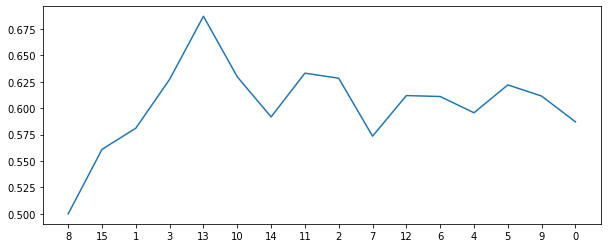

new features [1, 15, 13, 3, 8]
[0.5, 3, 1000, 1, 1, 1, 1.5, 3, 0.75, 0.1, 1.0]
accuracy     0.6303571428571428
specificity  0.6225867269984917
sensitivity  0.74
auc          0.6812933634992459


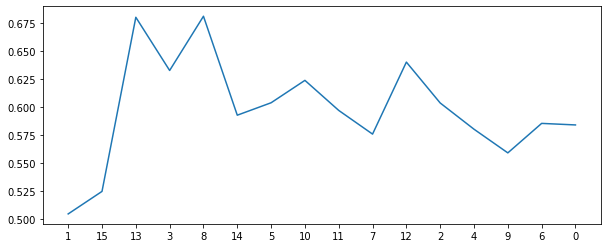

new features [8, 15, 1, 14, 3, 11, 13, 2]
[0.5, 3, 1000, 1, 1, 1, 1.5, 5, 0.5, 0.1, 0.8]
accuracy     0.5928571428571429
specificity  0.5782051282051281
sensitivity  0.785
auc          0.6816025641025641


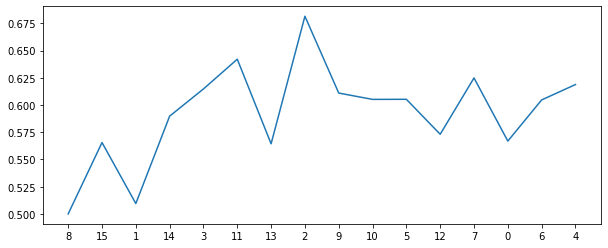

new features [8, 15, 10, 5, 11, 14, 3, 1, 13, 2, 12]
[0.5, 3, 1000, 3, 0, 0.75, 2, 3, 0.5, 0.1, 0.8]
accuracy     0.6875
specificity  0.6881598793363499
sensitivity  0.685
auc          0.686579939668175


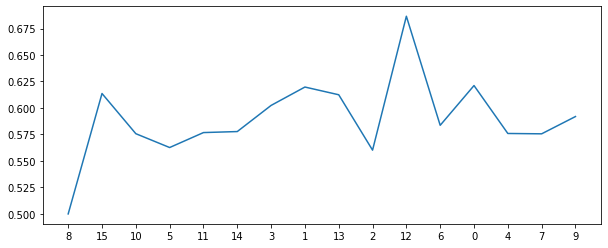

new features [8, 10, 15, 1, 3, 2]
[0.5, 3, 1000, 3, 0, 1, 1.5, 5, 0.75, 0.1, 0.8]
accuracy     0.6142857142857143
specificity  0.6033182503770739
sensitivity  0.765
auc          0.6841591251885369


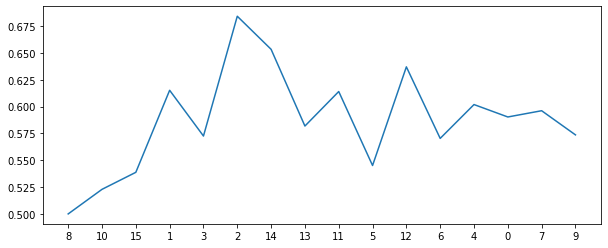

new features [10, 15, 8, 3, 5, 2, 1]
[0.5, 3, 1000, 3, 0, 1, 2, 4, 1.0, 0.1, 0.8]
accuracy     0.6339285714285714
specificity  0.6264705882352941
sensitivity  0.735
auc          0.6807352941176471


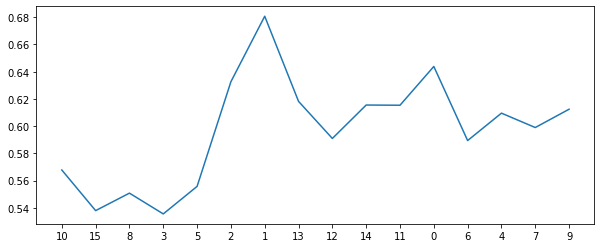

new features [8, 15, 10, 3, 2, 11]
[0.5, 3, 1000, 3, 0.5, 0.75, 1.5, 3, 0.5, 0.1, 0.8]
accuracy     0.6696428571428572
specificity  0.6687028657616892
sensitivity  0.695
auc          0.6818514328808446


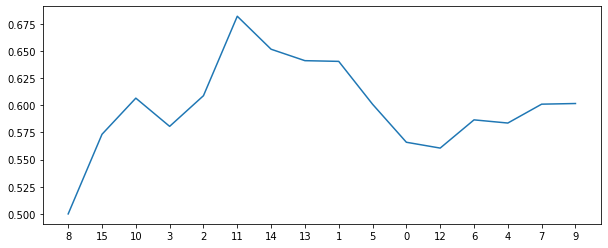

new features [8, 15, 10, 13, 3, 11, 14, 1, 2, 5]
[0.5, 3, 1000, 3, 0.5, 0.75, 1.5, 4, 0.5, 0.1, 1.0]
accuracy     0.6071428571428571
specificity  0.5936651583710407
sensitivity  0.785
auc          0.6893325791855204


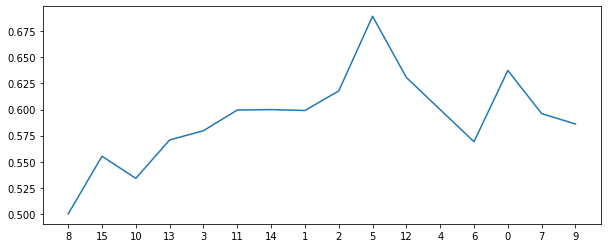

new features [8, 15, 2, 3, 12, 1]
[0.5, 3, 1000, 3, 0.5, 1, 1, 4, 1.0, 0.1, 1.0]
accuracy     0.5946428571428571
specificity  0.580316742081448
sensitivity  0.79
auc          0.685158371040724


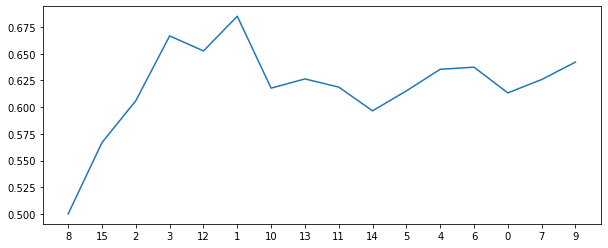

new features [15, 10, 8, 2, 3, 1]
[0.5, 3, 1000, 3, 1, 1, 2, 3, 1.0, 0.1, 1.0]
accuracy     0.6017857142857143
specificity  0.5879713423831071
sensitivity  0.79
auc          0.6889856711915535


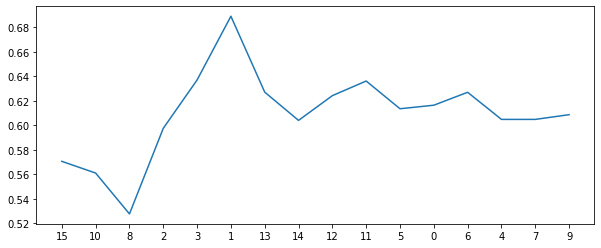

new features [8, 15, 2, 3, 11]
[0.5, 3, 1000, 4, 0, 0.5, 1.5, 4, 0.5, 0.1, 0.8]
accuracy     0.5928571428571429
specificity  0.5743966817496229
sensitivity  0.84
auc          0.7071983408748115


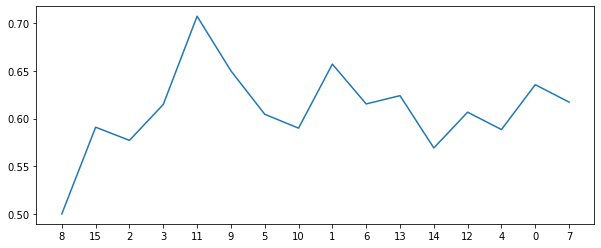

new features [8, 10, 15, 13, 3, 11, 2, 1]
[0.5, 3, 1000, 4, 0, 0.5, 1.5, 5, 0.5, 0.1, 1.0]
accuracy     0.5875
specificity  0.572473604826546
sensitivity  0.79
auc          0.681236802413273


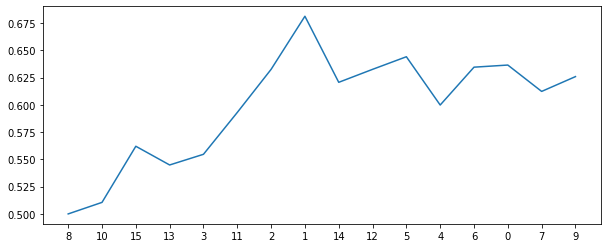

new features [8, 15, 10, 3, 2, 11, 1, 14, 13, 5, 12, 0, 4, 6, 7]
[0.5, 3, 1000, 4, 0, 1, 2, 4, 0.75, 0.1, 0.8]
accuracy     0.5910714285714286
specificity  0.5764328808446456
sensitivity  0.785
auc          0.6807164404223228


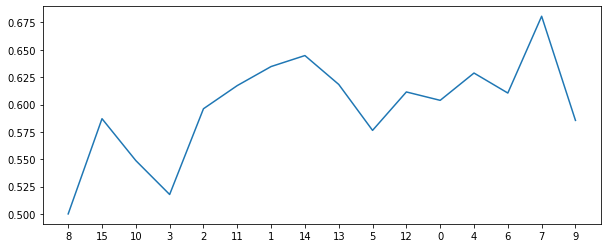

new features [15, 13, 8, 3, 10, 11, 14, 12, 2, 1, 4]
[0.5, 3, 1000, 4, 0.5, 0.5, 2, 4, 0.5, 0.1, 1.0]
accuracy     0.5714285714285714
specificity  0.5533182503770739
sensitivity  0.81
auc          0.681659125188537


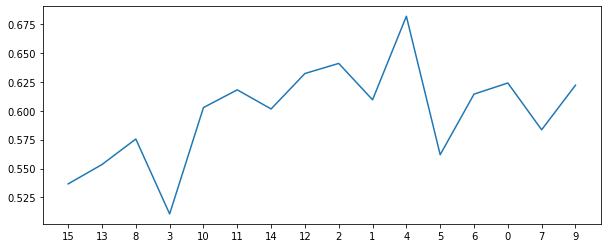

new features [15, 10, 8, 13, 3, 11, 2, 1, 14, 6, 5, 12]
[0.5, 3, 1000, 4, 0.5, 1, 1.5, 3, 0.75, 0.1, 1.0]
accuracy     0.6267857142857143
specificity  0.6168552036199095
sensitivity  0.76
auc          0.6884276018099548


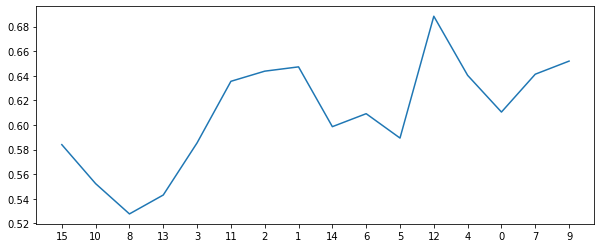

new features [10, 15, 1, 13, 3, 8, 11, 4, 14, 0, 6, 2]
[0.5, 3, 1000, 4, 1, 0.5, 2, 4, 0.75, 0.1, 1.0]
accuracy     0.5910714285714286
specificity  0.5763951734539969
sensitivity  0.785
auc          0.6806975867269985


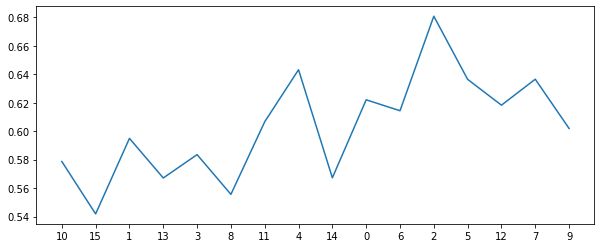

In [21]:
max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comb,MAX_feat,INDEXES,best_params_total= gridsearch(params)

In [22]:
print(MAX_feat)
print(MAX_comb)
print(MAX_acc)
print(MAX_spec)
print(MAX_sens)
print(MAX_auc)

[8, 15, 2, 3, 11]
[0.5, 3, 1000, 4, 0, 0.5, 1.5, 4, 0.5, 0.1, 0.8]
0.5928571428571429
0.5743966817496229
0.84
0.7071983408748115


In [23]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params_total)):
    if best_params_total[i][4] > 0.69:
        print("parameters :",best_params_total[i][0])
        print("accuracy :",best_params_total[i][1])
        print("spes     :",best_params_total[i][2])
        print("sens     :",best_params_total[i][3])
        print("auc      :",best_params_total[i][4])
        print(best_params_total[i][5])
        print(best_params_total[i][6])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.5, 2, 1000, 4, 0, 0.5, 1.5, 3, 0.5, 0.1, 0.8]
accuracy : 0.6303571428571428
spes     : 0.620475113122172
sens     : 0.765
auc      : 0.6927375565610859
[15, 8, 3, 2, 11]
[15, 8, 3, 2, 11, 10, 14, 12, 13, 5, 1, 6, 0, 4, 7, 9, 16]
------------------------------------------------
parameters : [0.5, 2, 1000, 4, 1, 0.5, 1.5, 5, 0.75, 0.1, 0.8]
accuracy : 0.5732142857142857
spes     : 0.5532051282051282
sens     : 0.835
auc      : 0.6941025641025641
[8, 10, 3, 15, 1, 2, 11, 5]
[8, 10, 3, 15, 1, 2, 11, 5, 13, 14, 6, 12, 4, 0, 7, 9, 16]
------------------------------------------------
parameters : [0.5, 3, 1000, 1, 0, 0.5, 1.5, 4, 0.5, 0.1, 1.0]
accuracy : 0.6375
spes     : 0.6283559577677225
sens     : 0.76
auc      : 0.6941779788838612
[9, 7, 13, 8, 15, 10, 3, 11, 12, 1, 2, 14]
[9, 7, 13, 8, 15, 10, 3, 11, 12, 1, 2, 14, 4, 5, 0, 6, 16]
------------------------------------------------
parameters : [0.5, 3, 1000, 1, 0, 0.5, 2, 5, 1.0, 0.1, 0.8]
accuracy : 0.6339285714285714
spe

In [24]:
IND = []
for i in range(len(INDEXES)):
    IND.append(INDEXES[i]//min(INDEXES))
print(IND)

[1, 2, 2, 3, 1, 2, 1, 1, 3, 1, 3, 2, 1, 3, 2, 4]


In [20]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.5],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2,3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1,2,3,4],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0,0.5,1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5,0.75,1], #0.5-1
                     "reg_lambda"      :[1, 1.5, 2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3,4,5],
                    "colsample_bytree" :[0.5,0.75,1.0],
                    "reg_alpha"        :[0.2],
                    "subsample"        :[0.8,1.0]
    
        }

3888
new features [7, 15, 8, 3, 10, 13, 1, 12]
[0.5, 2, 1000, 1, 0, 0.5, 2, 3, 1.0, 0.2, 1.0]
accuracy     0.65
specificity  0.643815987933635
sensitivity  0.735
auc          0.6894079939668175


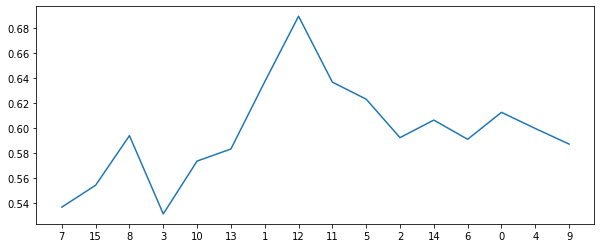

new features [7, 15, 3, 8, 13, 10, 12, 1, 11, 14, 6, 5, 2, 0, 4]
[0.5, 2, 1000, 1, 0, 0.5, 2, 5, 1.0, 0.2, 1.0]
accuracy     0.5589285714285714
specificity  0.5377450980392157
sensitivity  0.835
auc          0.6863725490196079


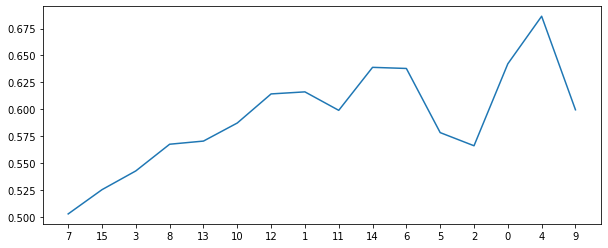

new features [15, 9, 3, 2, 10, 13, 11]
[0.5, 2, 1000, 2, 0, 0.5, 1.5, 3, 0.5, 0.2, 0.8]
accuracy     0.6535714285714286
specificity  0.6495475113122172
sensitivity  0.72
auc          0.6847737556561087


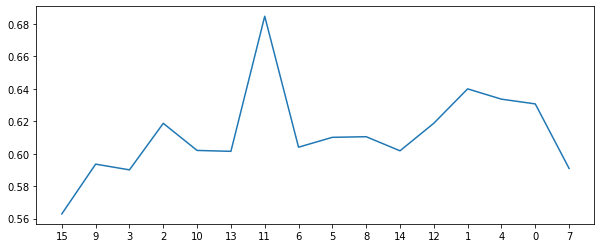

new features [9, 15, 8, 6, 10, 3, 1, 2]
[0.5, 2, 1000, 2, 0, 0.5, 1.5, 5, 1.0, 0.2, 0.8]
accuracy     0.5732142857142857
specificity  0.5552413273001509
sensitivity  0.815
auc          0.6851206636500754


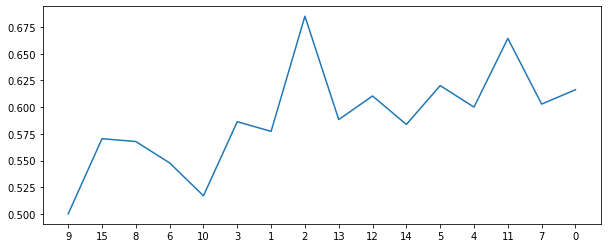

new features [10, 13, 15, 3, 8, 1, 5, 14, 11, 9, 0, 2]
[0.5, 2, 1000, 2, 0, 0.5, 2, 5, 0.75, 0.2, 1.0]
accuracy     0.5696428571428571
specificity  0.5513197586726999
sensitivity  0.81
auc          0.68065987933635


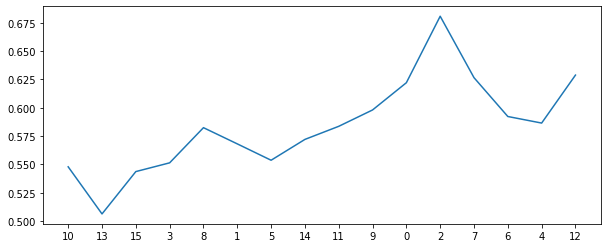

new features [10, 13, 8, 3, 15, 1, 14, 11, 2, 4, 12, 6, 0, 5, 7]
[0.5, 2, 1000, 2, 0, 0.75, 1, 5, 0.75, 0.2, 1.0]
accuracy     0.5767857142857142
specificity  0.5590874811463047
sensitivity  0.81
auc          0.6845437405731524


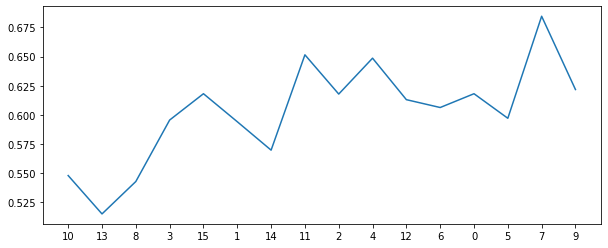

new features [8, 15, 13, 10, 3, 2, 11]
[0.5, 2, 1000, 2, 0, 0.75, 2, 3, 0.5, 0.2, 1.0]
accuracy     0.65
specificity  0.645739064856712
sensitivity  0.715
auc          0.680369532428356


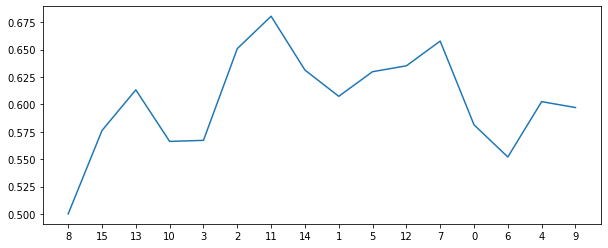

new features [8, 9, 10, 15, 3, 5, 13, 1, 2, 11, 14, 12, 6]
[0.5, 2, 1000, 2, 0, 1, 1.5, 4, 0.5, 0.2, 0.8]
accuracy     0.6196428571428572
specificity  0.609238310708899
sensitivity  0.76
auc          0.6846191553544495


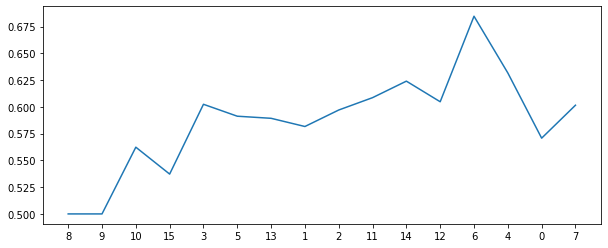

new features [10, 8, 15, 3, 1, 13, 11, 14, 0, 6, 5, 2, 12, 4, 7]
[0.5, 2, 1000, 3, 0, 0.5, 1, 4, 0.75, 0.2, 1.0]
accuracy     0.6017857142857143
specificity  0.58789592760181
sensitivity  0.785
auc          0.686447963800905


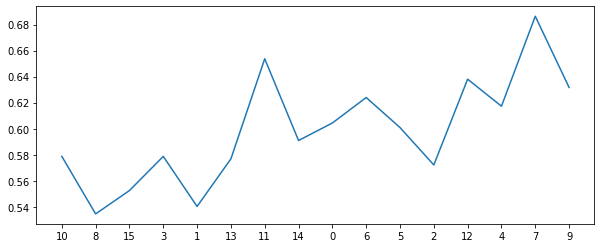

new features [8, 10, 15, 3, 1, 5, 2, 11]
[0.5, 2, 1000, 3, 0, 0.5, 1.5, 4, 0.75, 0.2, 0.8]
accuracy     0.6464285714285715
specificity  0.639894419306184
sensitivity  0.735
auc          0.687447209653092


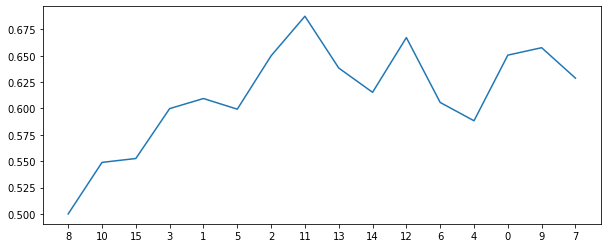

new features [10, 15, 8, 13, 5, 3, 1, 11, 14, 6, 2]
[0.5, 2, 1000, 3, 0, 0.5, 2, 4, 0.75, 0.2, 1.0]
accuracy     0.5946428571428571
specificity  0.5802413273001509
sensitivity  0.785
auc          0.6826206636500755


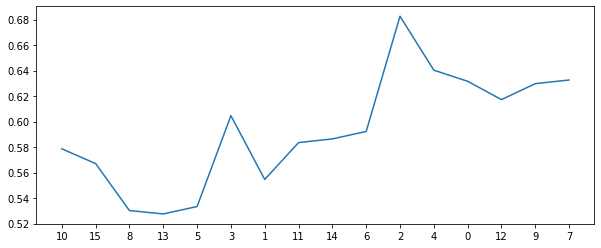

new features [8, 10, 15, 13, 3, 1, 11, 14, 2]
[0.5, 2, 1000, 3, 0, 0.5, 2, 5, 0.75, 0.2, 0.8]
accuracy     0.6107142857142857
specificity  0.5995475113122172
sensitivity  0.765
auc          0.6822737556561086


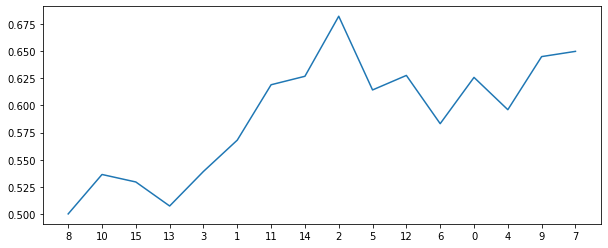

new features [8, 10, 15, 11, 2, 3]
[0.5, 2, 1000, 3, 0, 1, 1, 5, 0.5, 0.2, 0.8]
accuracy     0.6035714285714285
specificity  0.5918174962292609
sensitivity  0.77
auc          0.6809087481146305


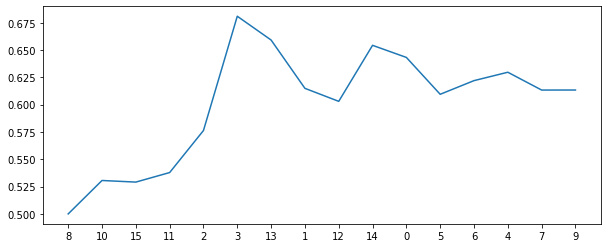

new features [8, 10, 15, 13, 3, 11, 4, 14, 2, 1]
[0.5, 2, 1000, 3, 0.5, 0.75, 1, 3, 0.5, 0.2, 1.0]
accuracy     0.6607142857142857
specificity  0.6572021116138763
sensitivity  0.71
auc          0.6836010558069382


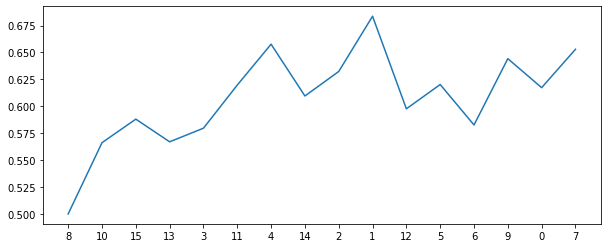

new features [15, 8, 2, 3, 11]
[0.5, 2, 1000, 4, 0, 0.5, 2, 4, 0.5, 0.2, 0.8]
accuracy     0.5767857142857142
specificity  0.5589366515837104
sensitivity  0.815
auc          0.6869683257918552


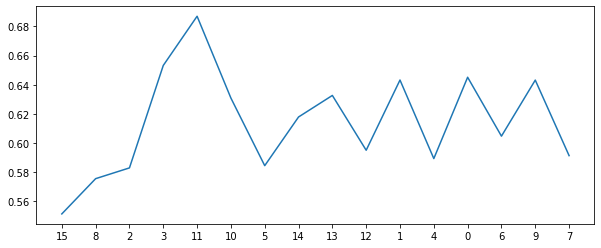

new features [10, 15, 13, 8, 11, 3, 1, 14, 2, 5, 6, 4, 12, 0]
[0.5, 2, 1000, 4, 0.5, 0.5, 2, 3, 0.75, 0.2, 1.0]
accuracy     0.6410714285714285
specificity  0.6341628959276018
sensitivity  0.735
auc          0.6845814479638009


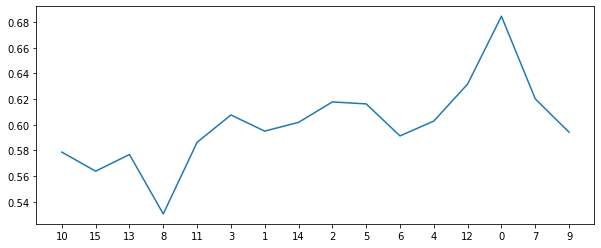

new features [15, 3, 8, 2, 5]
[0.5, 2, 1000, 4, 0.5, 1, 2, 5, 1.0, 0.2, 0.8]
accuracy     0.5553571428571429
specificity  0.5338612368024133
sensitivity  0.835
auc          0.6844306184012067


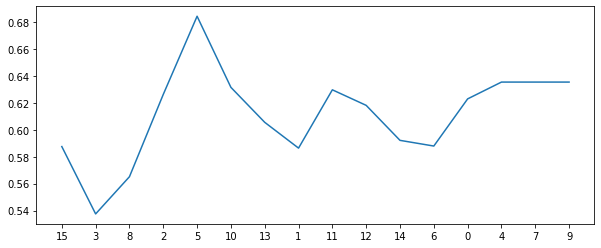

new features [9, 15, 8, 3, 2, 7, 1, 13, 12, 11, 10, 14]
[0.5, 3, 1000, 1, 0, 0.5, 1, 4, 0.5, 0.2, 0.8]
accuracy     0.6517857142857143
specificity  0.6475113122171946
sensitivity  0.715
auc          0.6812556561085973


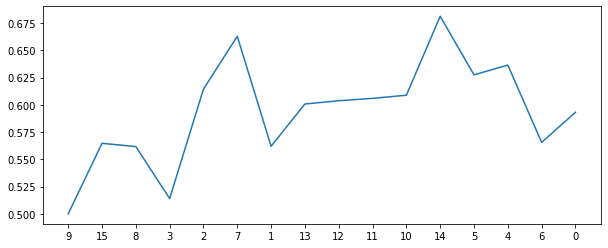

new features [8, 1, 14, 15, 13, 9, 10, 3, 5, 11, 2, 12, 6, 7, 4]
[0.5, 3, 1000, 1, 0, 0.5, 1.5, 3, 0.75, 0.2, 0.8]
accuracy     0.7142857142857143
specificity  0.720814479638009
sensitivity  0.64
auc          0.6804072398190045


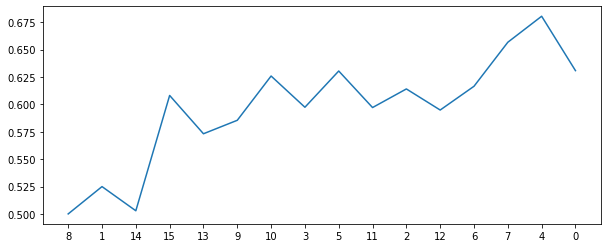

new features [8, 13, 15, 10, 3, 9, 11, 2, 1, 7, 14, 4]
[0.5, 3, 1000, 1, 0, 0.75, 1.5, 3, 0.5, 0.2, 1.0]
accuracy     0.6803571428571429
specificity  0.6803921568627451
sensitivity  0.69
auc          0.6851960784313725


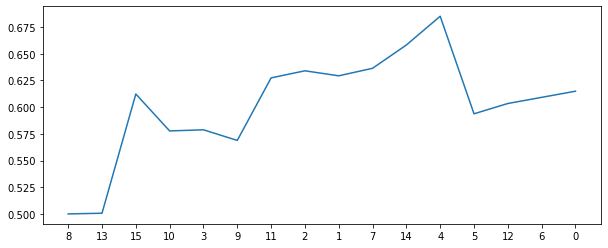

new features [8, 13, 3, 15, 7, 10, 11, 1, 2, 14]
[0.5, 3, 1000, 1, 0, 0.75, 1.5, 5, 0.5, 0.2, 1.0]
accuracy     0.6017857142857143
specificity  0.5878205128205128
sensitivity  0.785
auc          0.6864102564102564


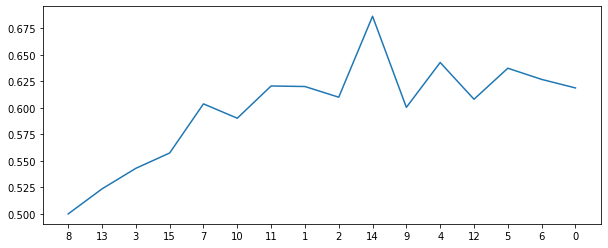

new features [7, 8, 15, 1, 13, 2, 10, 3, 11, 14, 12]
[0.5, 3, 1000, 1, 0, 0.75, 2, 4, 1.0, 0.2, 0.8]
accuracy     0.6339285714285714
specificity  0.6264328808446455
sensitivity  0.74
auc          0.6832164404223228


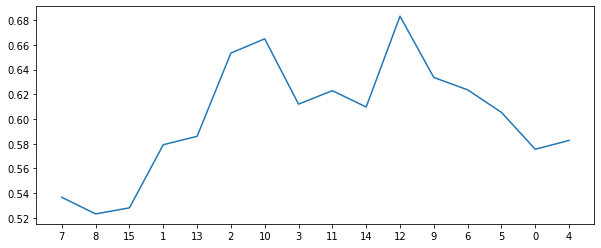

new features [8, 9, 15, 10, 13, 3, 11, 1]
[0.5, 3, 1000, 1, 0, 1, 1.5, 3, 0.5, 0.2, 1.0]
accuracy     0.6732142857142858
specificity  0.6725113122171946
sensitivity  0.69
auc          0.6812556561085973


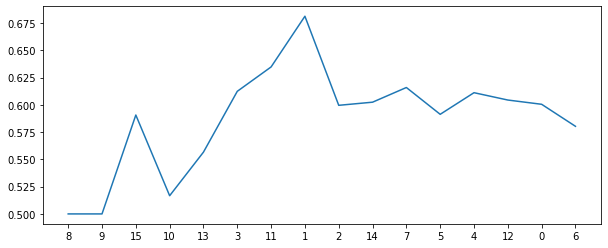

new features [7, 9, 8, 15, 3, 1, 2]
[0.5, 3, 1000, 1, 0, 1, 2, 4, 1.0, 0.2, 0.8]
accuracy     0.6357142857142857
specificity  0.6283182503770739
sensitivity  0.74
auc          0.6841591251885369


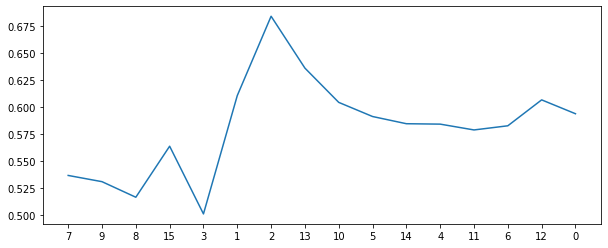

new features [9, 8, 4, 15, 13, 3, 12, 11, 10, 14, 2]
[0.5, 3, 1000, 1, 0.5, 0.5, 1.5, 3, 0.5, 0.2, 1.0]
accuracy     0.6482142857142857
specificity  0.6418174962292609
sensitivity  0.74
auc          0.6909087481146304


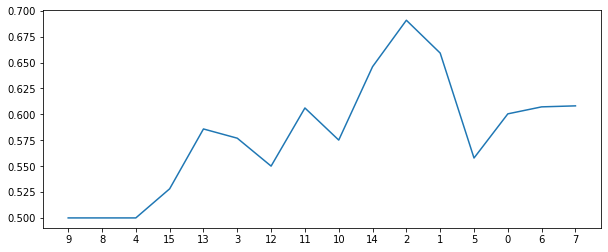

new features [15, 3, 10, 8, 2, 1, 9, 11, 5]
[0.5, 3, 1000, 1, 0.5, 0.5, 2, 5, 0.5, 0.2, 0.8]
accuracy     0.5732142857142857
specificity  0.5552413273001509
sensitivity  0.805
auc          0.6801206636500754


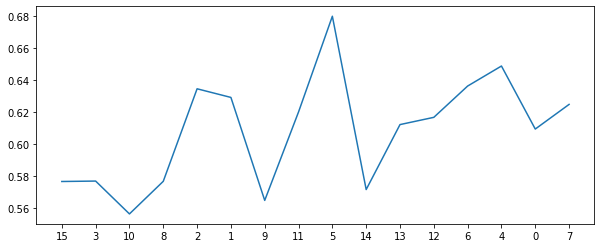

new features [1, 3, 15, 2]
[0.5, 3, 1000, 1, 1, 0.5, 1.5, 4, 1.0, 0.2, 0.8]
accuracy     0.6196428571428572
specificity  0.6090874811463047
sensitivity  0.765
auc          0.6870437405731523


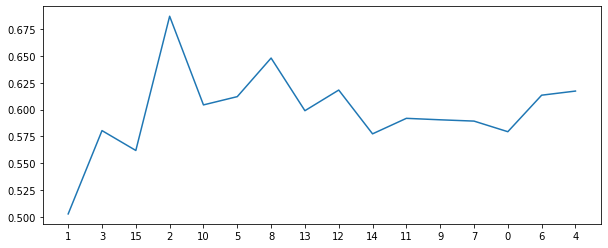

new features [15, 1, 8, 3, 13, 2]
[0.5, 3, 1000, 1, 1, 0.75, 1.5, 4, 1.0, 0.2, 0.8]
accuracy     0.6232142857142857
specificity  0.612707390648567
sensitivity  0.76
auc          0.6863536953242836


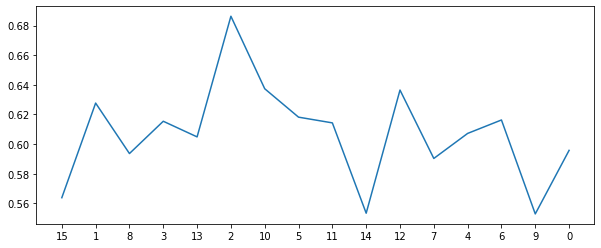

new features [15, 1, 13, 3, 8]
[0.5, 3, 1000, 1, 1, 1, 1, 3, 0.75, 0.2, 1.0]
accuracy     0.6321428571428571
specificity  0.6243212669683258
sensitivity  0.74
auc          0.6821606334841629


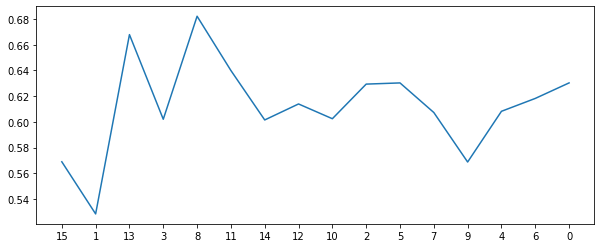

new features [9, 15, 8, 3, 13, 10, 14, 11, 2, 12]
[0.5, 3, 1000, 2, 0, 0.5, 1.5, 5, 0.5, 0.2, 0.8]
accuracy     0.6196428571428572
specificity  0.6089366515837104
sensitivity  0.765
auc          0.6869683257918552


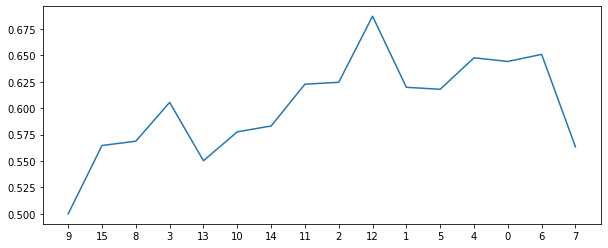

new features [1, 8, 10, 3, 15, 13, 2, 11]
[0.5, 3, 1000, 2, 1, 0.75, 1, 4, 0.75, 0.2, 1.0]
accuracy     0.6160714285714286
specificity  0.6052413273001508
sensitivity  0.765
auc          0.6851206636500754


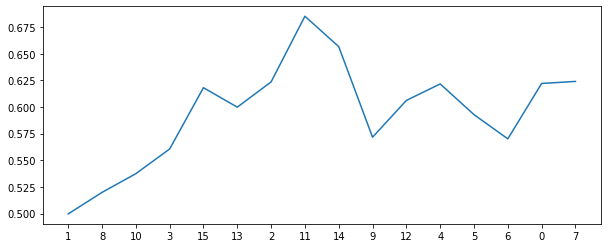

new features [15, 3, 10, 8, 13, 14, 12, 2]
[0.5, 3, 1000, 2, 1, 0.75, 2, 5, 1.0, 0.2, 0.8]
accuracy     0.5964285714285714
specificity  0.5820889894419307
sensitivity  0.785
auc          0.6835444947209653


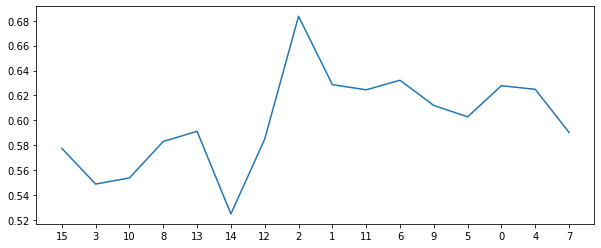

new features [8, 15, 10, 3, 11, 2, 13]
[0.5, 3, 1000, 3, 0, 1, 2, 3, 0.75, 0.2, 1.0]
accuracy     0.65
specificity  0.6457013574660634
sensitivity  0.715
auc          0.6803506787330317


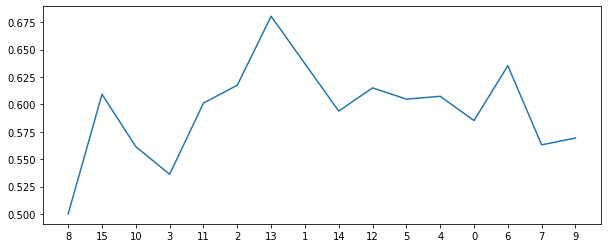

new features [10, 15, 13, 1, 3, 14, 11]
[0.5, 3, 1000, 3, 0.5, 0.5, 1, 4, 0.75, 0.2, 1.0]
accuracy     0.6160714285714286
specificity  0.6053167420814479
sensitivity  0.765
auc          0.685158371040724


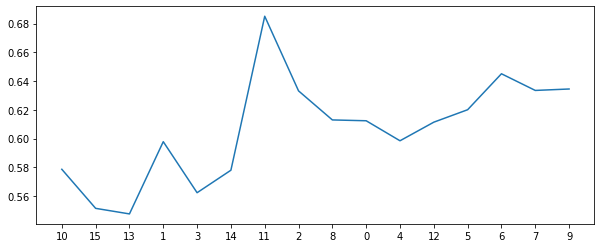

new features [10, 8, 15, 3, 1, 11, 5]
[0.5, 3, 1000, 3, 0.5, 0.5, 1, 5, 0.75, 0.2, 0.8]
accuracy     0.5803571428571429
specificity  0.56289592760181
sensitivity  0.805
auc          0.683947963800905


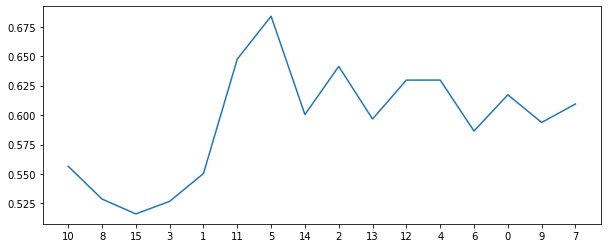

new features [8, 15, 12, 13, 1, 2]
[0.5, 3, 1000, 3, 1, 1, 1, 4, 1.0, 0.2, 1.0]
accuracy     0.5517857142857143
specificity  0.5301282051282051
sensitivity  0.84
auc          0.6850641025641026


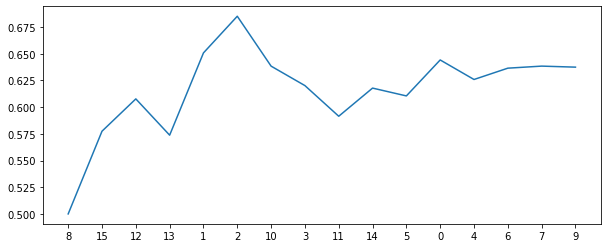

new features [8, 15, 1, 3, 2]
[0.5, 3, 1000, 3, 1, 1, 1.5, 4, 0.75, 0.2, 0.8]
accuracy     0.5785714285714286
specificity  0.560972850678733
sensitivity  0.815
auc          0.6879864253393665


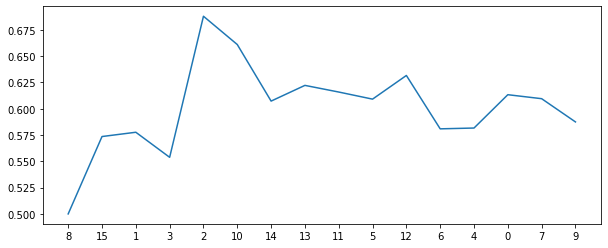

new features [15, 8, 13, 3, 1, 10, 11, 14, 12, 2, 5, 0]
[0.5, 3, 1000, 3, 1, 1, 2, 3, 0.75, 0.2, 1.0]
accuracy     0.6339285714285714
specificity  0.626395173453997
sensitivity  0.735
auc          0.6806975867269985


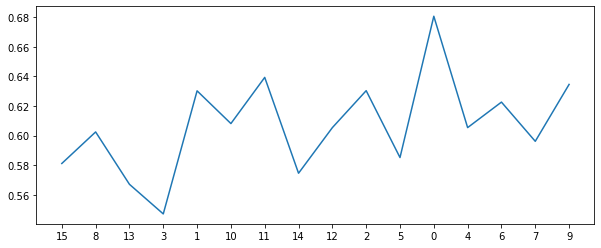

new features [8, 10, 15, 13, 11, 3, 2]
[0.5, 3, 1000, 4, 0, 0.75, 1, 5, 0.5, 0.2, 1.0]
accuracy     0.5714285714285714
specificity  0.5532428355957768
sensitivity  0.815
auc          0.6841214177978884


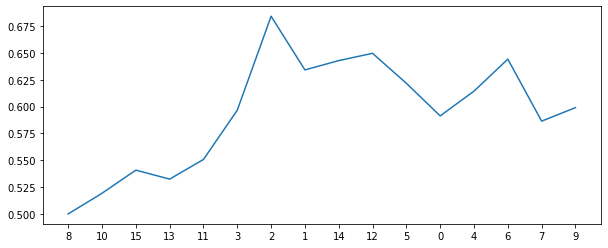

new features [8, 15, 10, 3, 4, 11, 13, 1, 2, 5, 14]
[0.5, 3, 1000, 4, 0, 0.75, 2, 3, 0.5, 0.2, 1.0]
accuracy     0.6553571428571429
specificity  0.6494720965309201
sensitivity  0.735
auc          0.69223604826546


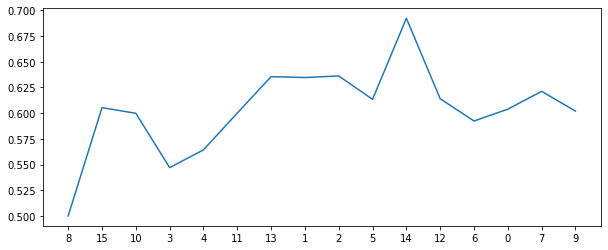

new features [15, 10, 8, 11, 13, 3, 2, 1, 14, 12, 0, 6, 5, 4, 7, 9]
[0.5, 3, 1000, 4, 0.5, 1, 1.5, 3, 0.75, 0.2, 1.0]
accuracy     0.6392857142857142
specificity  0.6322021116138763
sensitivity  0.735
auc          0.6836010558069382


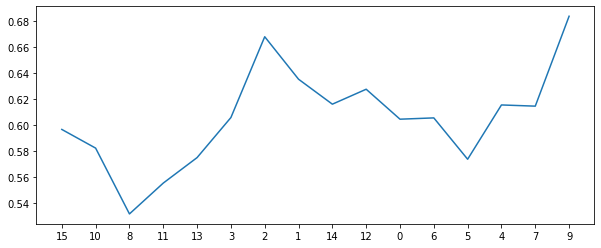

new features [3, 15, 10, 13, 11, 12, 14, 8, 2, 1, 4]
[0.5, 3, 1000, 4, 1, 0.5, 1, 3, 0.5, 0.2, 1.0]
accuracy     0.6160714285714286
specificity  0.6051282051282052
sensitivity  0.76
auc          0.6825641025641026


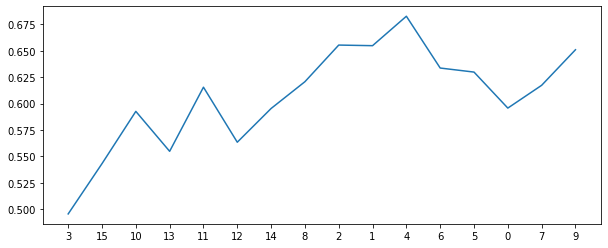

new features [15, 3, 11, 10, 13, 8, 1, 2]
[0.5, 3, 1000, 4, 1, 0.5, 2, 3, 1.0, 0.2, 1.0]
accuracy     0.6125
specificity  0.6014705882352941
sensitivity  0.76
auc          0.6807352941176471


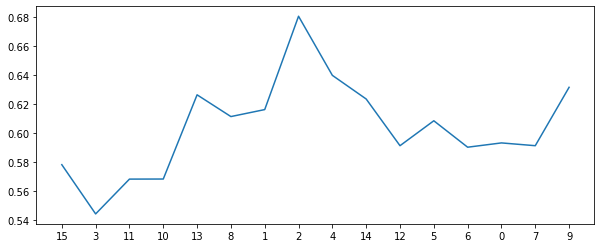

new features [15, 8, 13, 3, 1, 2]
[0.5, 3, 1000, 4, 1, 0.75, 1.5, 3, 1.0, 0.2, 0.8]
accuracy     0.6464285714285715
specificity  0.6396681749622926
sensitivity  0.74
auc          0.6898340874811463


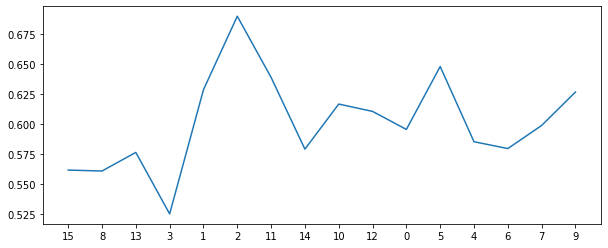

In [21]:
max_sens, max_params, max_spes, max_acc, max_auc, best_params,MAX_auc,MAX_spec,MAX_sens,MAX_acc,MAX_comb,MAX_feat,INDEXES,best_params_total= gridsearch(params)

In [22]:
print(MAX_feat)
print(MAX_comb)
print(MAX_acc)
print(MAX_spec)
print(MAX_sens)
print(MAX_auc)

[8, 15, 10, 3, 4, 11, 13, 1, 2, 5, 14]
[0.5, 3, 1000, 4, 0, 0.75, 2, 3, 0.5, 0.2, 1.0]
0.6553571428571429
0.6494720965309201
0.735
0.69223604826546


In [23]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params_total)):
    if best_params_total[i][4] > 0.69:
        print("parameters :",best_params_total[i][0])
        print("accuracy :",best_params_total[i][1])
        print("spes     :",best_params_total[i][2])
        print("sens     :",best_params_total[i][3])
        print("auc      :",best_params_total[i][4])
        print(best_params_total[i][5])
        print(best_params_total[i][6])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.5, 3, 1000, 1, 0.5, 0.5, 1.5, 3, 0.5, 0.2, 1.0]
accuracy : 0.6482142857142857
spes     : 0.6418174962292609
sens     : 0.74
auc      : 0.6909087481146304
[9, 8, 4, 15, 13, 3, 12, 11, 10, 14, 2]
[9, 8, 4, 15, 13, 3, 12, 11, 10, 14, 2, 1, 5, 0, 6, 7, 16]
------------------------------------------------
parameters : [0.5, 3, 1000, 4, 0, 0.75, 2, 3, 0.5, 0.2, 1.0]
accuracy : 0.6553571428571429
spes     : 0.6494720965309201
sens     : 0.735
auc      : 0.69223604826546
[8, 15, 10, 3, 4, 11, 13, 1, 2, 5, 14]
[8, 15, 10, 3, 4, 11, 13, 1, 2, 5, 14, 12, 6, 0, 7, 9, 16]
------------------------------------------------
2


In [24]:
IND = []
for i in range(len(INDEXES)):
    IND.append(INDEXES[i]//min(INDEXES))
print(IND)

[1, 2, 2, 3, 1, 2, 1, 1, 3, 1, 3, 2, 1, 3, 2, 4]


In [ ]:
#έγινε ==> auc: 0.7297171945701357
parameters : [0.4, 3, 1000, 4, 0.5, 0.5, 2, 3, 0.5, 0, 1.0]
accuracy : 0.6285714285714286
spes     : 0.616817496229261
sens     : 0.785
auc      : 0.7009087481146304
[14, 15, 3, 13, 11, 1, 2, 12, 5, 10, 8]
[14, 15, 3, 13, 11, 1, 2, 12, 5, 10, 8, 0, 4, 6, 7, 9, 16]

#έγινε ==> auc:  0.6989856711915535
parameters : [0.4, 3, 1000, 3, 0, 0.5, 1.5, 4, 0.75, 0.1, 0.8]
accuracy : 0.65
spes     : 0.6418929110105581
sens     : 0.76
auc      : 0.700946455505279
[14, 3, 11, 13, 1, 15, 2, 12, 5, 10, 4, 0, 6, 8]
[14, 3, 11, 13, 1, 15, 2, 12, 5, 10, 4, 0, 6, 8, 7, 9, 16]

#έγινε ==> auc: 0.6740045248868778
parameters : [0.4, 3, 1000, 2, 0.5, 0.5, 1, 3, 0.5, 0.2, 1.0]
accuracy : 0.65
spes     : 0.6438536953242836
sens     : 0.74
auc      : 0.6919268476621417
[3, 15, 11, 14, 13, 1, 2, 12, 10, 5]
[3, 15, 11, 14, 13, 1, 2, 12, 10, 5, 8, 4, 6, 0, 7, 9, 16]

#έγινε ==> auc: 0.7355429864253394
parameters : [0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0, 1.0]
accuracy : 0.6625
spes     : 0.6572398190045249
sens     : 0.735
auc      : 0.6961199095022624
[3, 14, 13, 1, 11, 2, 15, 12, 5, 10, 8]
[3, 14, 13, 1, 11, 2, 15, 12, 5, 10, 8, 6, 4, 0, 9, 7, 16]

parameters : [0.5, 2, 1000, 1, 0.5, 0.5, 1.5, 4, 0.75, 0.1, 0.8]
accuracy : 0.6178571428571429
spes     : 0.6052790346907994
sens     : 0.79
auc      : 0.6976395173453998
[14, 13, 3, 11, 1, 15, 2, 12]
[14, 13, 3, 11, 1, 15, 2, 12, 10, 5, 8, 4, 6, 0, 9, 7, 16] 
 
parameters : [0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0.2, 1.0]
accuracy : 0.6589285714285714
spes     : 0.653393665158371
sens     : 0.735
auc      : 0.6941968325791855
[3, 14, 15, 13, 2, 1, 11, 12, 5, 10]
[3, 14, 15, 13, 2, 1, 11, 12, 5, 10, 8, 6, 0, 4, 9, 7, 16]

parameters : [0.3, 3, 1000, 2, 0, 0.5, 1.5, 5, 0.75, 0.1, 0.8]
accuracy : 0.5857142857142857
spes     : 0.5687028657616893
sens     : 0.815
auc      : 0.6918514328808447
[3, 14, 11, 13, 15, 2, 1, 12]
[3, 14, 11, 13, 15, 2, 1, 12, 10, 5, 4, 6, 8, 0, 9, 7, 16]

